In [4]:
#Necessary imports
import numpy as np
import pandas as pd
from scipy import signal
from scipy.interpolate import UnivariateSpline
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from pathlib import Path
import os
import shutil
import darts
from darts.ad import QuantileDetector, ThresholdDetector
from darts.ad.detectors.iqr_detector import IQRDetector
from darts import TimeSeries
from adtk.data import validate_series
from adtk.detector import SeasonalAD, AutoregressionAD
from adtk.visualization import plot
from hampel import hampel
import warnings
import neurokit2 as nk
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
#Start directory here for now
Data_Path = Path(r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\0_raw')

In [3]:
tempResp = r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\0_raw\14\0_14-06-02.csv'

Entry = pd.read_csv(tempResp) #Turns it into Panda Frame for ease of filtering


In [4]:
Entry

Time  Respiration  Events
0        0.0005    -0.018005     0.0
1        0.0010    -0.018005     0.0
2        0.0015    -0.018005     0.0
3        0.0020    -0.018005     0.0
4        0.0025    -0.018005     0.0
...         ...          ...     ...
167738  83.8695     0.046387     0.0
167739  83.8700     0.046387     0.0
167740  83.8705     0.046387     0.0
167741  83.8710     0.046387     0.0
167742  83.8715     0.046387     0.0

[167743 rows x 3 columns]

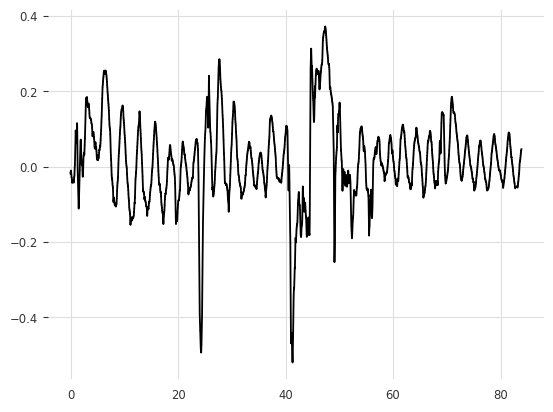

In [5]:
plt.plot(Entry['Time'][:200000],Entry['Respiration'][:200000])

In [10]:
#This will be the preprocessing and filtrering

#Make all Parameters needed for Butterworth Bandpass filter

def ApplyBandpass(df,sm_rate,lw_cut=0.05,hg_cut=2.0,order=1,output='None'):
    
    # Create Bandpass filter 
    b, a = signal.butter(order, [lw_cut,hg_cut],fs=sm_rate, btype='bandpass')
    # Print filter coefficients to verify
    # print(f"Butterworth Filter Coefficients:\nB = {b}\nA = {a}")
    
    #Apply Filter with Padding (Filtfilt)
    resp_data = df['Respiration'].values
    filt_data = signal.filtfilt(b,a, resp_data)
    
    if output != 'None':
        df_filt = pd.DataFrame({
                'Time': df['Time'].values,
                'Respiration': filt_data,
                'Events': df['Events'].values
            })

        df_filt.to_csv(output, index=False)
    #Return Filtered Results
    return filt_data

In [27]:
from pathlib import Path
import os
import shutil
import pandas as pd

def Preprocessing(input_raw_dir,
                  output_filtered_dir,
                  sm_rate=2000,
                  lw_cut=0.05,
                  hg_cut=2.0,
                  pad_len=0,
                  order=5):
    """
    Iterate through all participant subfolders in `input_raw_dir`, apply a
    Butterworth bandpass filter (via ApplyBandpass) to each CSV's
    respiration signal, and save the filtered output (Time, Respiration, Events)
    into `output_filtered_dir`.

    Parameters
    ----------
    input_raw_dir : str or Path
        Folder of raw CSV subdirectories.
    output_filtered_dir : str or Path
        Where filtered CSVs will be written, in subfolders '01/', '02/', …
    sm_rate : int, default=2000
        Sampling rate (Hz).
    lw_cut : float, default=0.05
        Low‑cut frequency (Hz).
    hg_cut : float, default=2.0
        High‑cut frequency (Hz).
    pad_len : int, default=0
        Padding length for the filter (currently unused).
    order : int, default=5
        Butterworth filter order (must be ≥ 1).
    """
    raw_path = Path(input_raw_dir)
    out_base = Path(output_filtered_dir)
    count = 1

    for participant_dir in sorted(raw_path.iterdir()):
        if not participant_dir.is_dir():
            continue

        out_dir = out_base / f"{count:02d}"
        if out_dir.exists():
            shutil.rmtree(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)

        for csv_file in participant_dir.glob("*.csv"):
            df = pd.read_csv(csv_file)
            data_id = csv_file.stem[-8:]
            output_csv = out_dir / f"1_{data_id}.csv"

            ApplyBandpass(
                df,
                sm_rate=sm_rate,
                lw_cut=lw_cut,
                hg_cut=hg_cut,
                order=order,
                output=str(output_csv)
            )
        count += 1

In [28]:
count = 1
sm_rate = 2000
lw_cut = 0.05
hg_cut = 2.0
pad_len = 0
output_path = f'data/1_filtered/'
order = 5

input_raw_dir = r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\0_raw'
Preprocessing(input_raw_dir, output_path, sm_rate, lw_cut, hg_cut, pad_len,order)

KeyboardInterrupt: 

In [11]:
# Fs = 2000  # Sampling frequency in Hz
# resp_data = np.array(Entry)[:, 1] #Just get the resp data
# time_data = np.array(Entry)[:, 0]
# lw_cut = 0.05
# hg_cut = 1
# N = len(resp_data)

# fft_result = fft(resp_data) #perform fft
# freqs = fftfreq(N, 1/Fs)  # Frequency bins

# mean_magnitude = np.mean(np.abs(fft_result))
# std_deviation = np.std(np.abs(fft_result))

# # Step 3: Compute Z-Scores
# z_scores = (np.abs(fft_result) - mean_magnitude) / std_deviation

# # Step 4: Identify Outliers Based on Z-Score Threshold
# threshold = 2  # Common threshold for Z-scores
# outlier_mask = np.where(np.abs(z_scores) > threshold, 1, 0)

# # Step 5: Adjust Outlier Values in Frequency Domain
# adjusted_fft = fft_result.copy()
# for i in range(len(outlier_mask)):
#     if outlier_mask[i]:
#         adjusted_fft[i] = mean_magnitude  # Replace with a suitable value

# filtered_data = ifft(filtered_fft).real  # Convert back to time domain and take real part

# plt.figure(figsize=(12, 8))
# plt.subplot(2, 1, 1)
# plt.plot(time_data, resp_data)
# plt.title('Original Time Domain Signal')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# plt.subplot(2, 1, 2)
# plt.plot(freqs, np.abs(fft_result))
# plt.title('Frequency Domain Response')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude')

# plt.tight_layout()
# plt.show()

# Plot filtered signal
# plt.figure(figsize=(12, 8))
# plt.plot(Entry['Time'],Entry['Respiration'])
# plt.title('Filtered Time Domain Signal')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# plt.plot(Entry_filt['Time'],Entry_filt['Respiration'])

# plt.plot(Entry_filt['Time'],Entry['Events'])
# plt.tight_layout()
# plt.show()

In [3]:
rawResp = r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\0_raw\01\0_01-02-01.csv'
filtResp = r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\01\1_01-02-01.csv'
Entry = pd.read_csv(rawResp)
Entry_filt = pd.read_csv(filtResp)

In [ ]:
df_rsp_kd2018, info = nk.rsp_process(Entry["Respiration"], sampling_rate=2000)
df_rsp_bs, info = nk.rsp_process(Entry["Respiration"], sampling_rate=2000, method="biosppy")

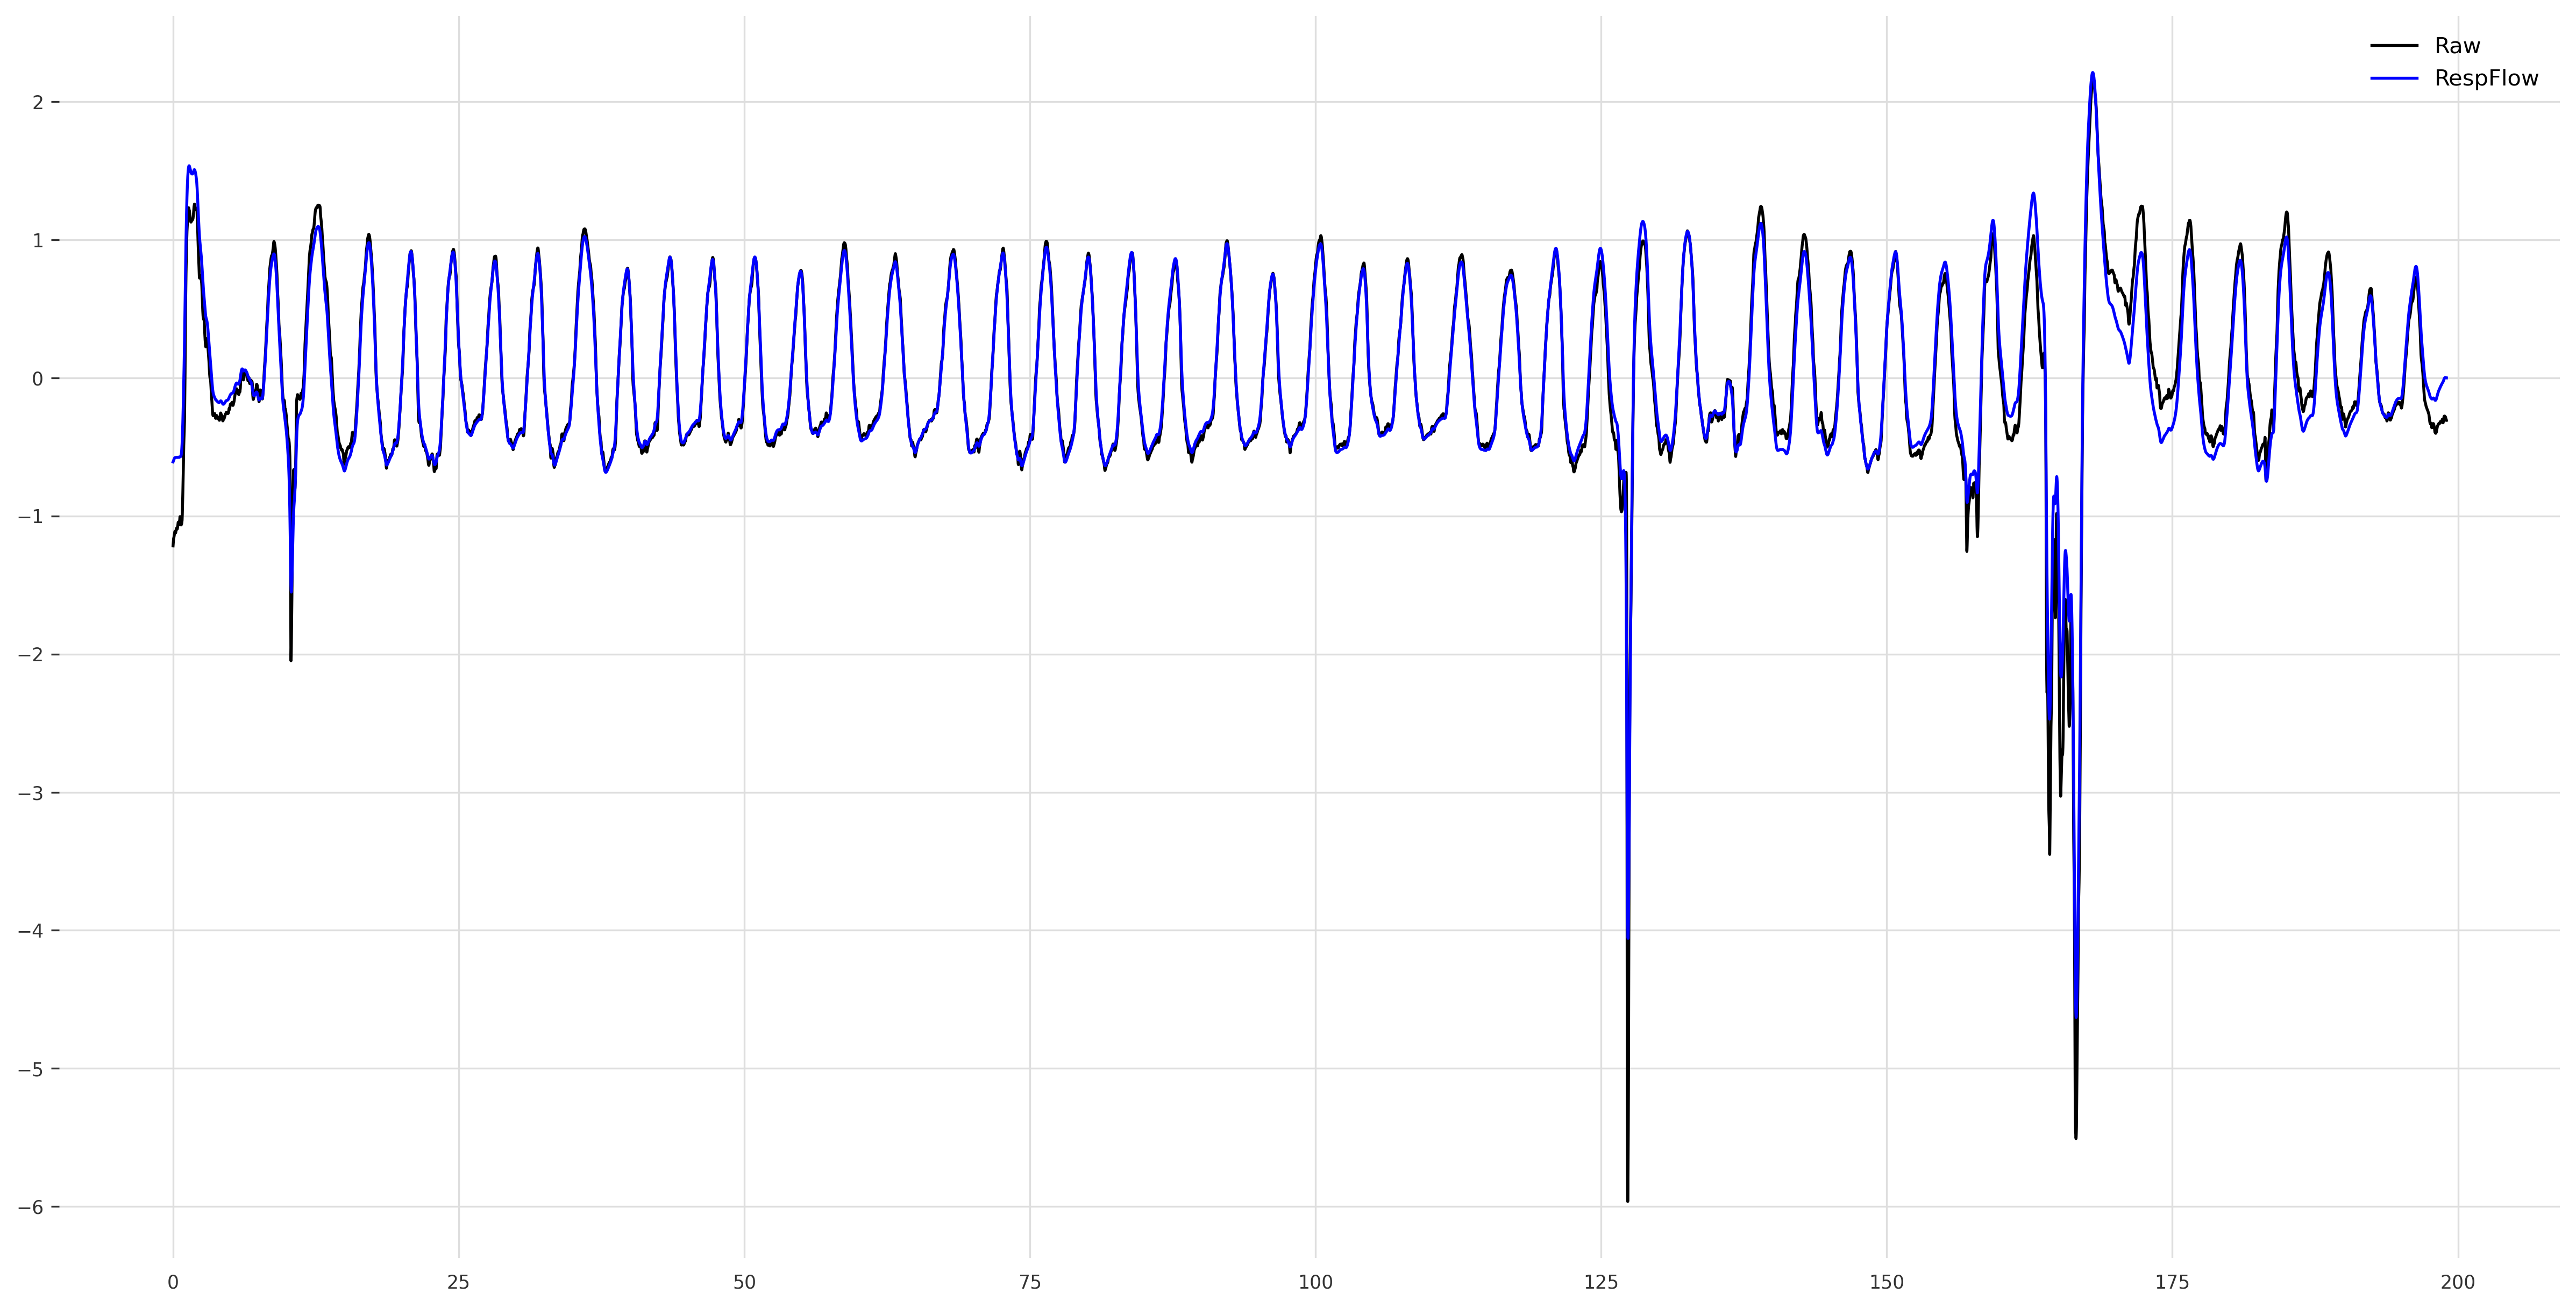

In [79]:
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(Entry['Time'],Entry['Respiration'], 'black', label='Raw')

plt.plot(Entry_filt['Time'],Entry_filt['Respiration'], 'b', label='RespFlow')
# plt.plot(Entry["Time"], df_rsp_kd2018["RSP_Clean"], label="khodadad2018", color="g")
# plt.plot(Entry["Time"], df_rsp_bs["RSP_Clean"], label="biosppy", color="r")
plt.legend()

plt.savefig(r'D:\Thesis Data\Thesis Data\RepirationToolKit\respiration_comparison.png', bbox_inches='tight')

In [5]:
def AD_Format(series):
    step = 0.0005
    tol = 0.005
    section = [series.iloc[0]]
    ranges = []
    
    # Create initial ranges based on the step and tolerance conditions
    for i in range(1, len(series)):
        diff = series.iloc[i] - series.iloc[i-1]
        if abs(diff - step) < tol:
            section.append(series.iloc[i])
        else:
            ranges.append((section[0], section[-1]))
            section = [series.iloc[i]]
    if section:
        ranges.append((section[0], section[-1]))

    # Merge ranges that are close together (within a gap of 10 in this case)
    merged = []
    current_start, current_end = ranges[0]
    
    # Iterate over the remaining ranges with debug prints
    for next_start, next_end in ranges[1:]:
        gap = next_start - current_end
        if gap < 10:
            # Debug print: merging tuples
            current_end = next_end  # Extend the current tuple's end
        else:
            # Not merging: append the current tuple and start a new one
            merged.append((current_start, current_end))
            current_start, current_end = next_start, next_end
    
    # Append the final range
    merged.append((current_start, current_end))
    return merged

In [70]:
def anomaly_det(df,Q_high_quantile=0.99, IQR_scale=3, AD_c=5, AD_side="both",AD_n_steps = 3, AD_step_size = 100, H_window_size=10, H_summary=False, verbose=False, ignore_warn=True, name="Temp",Return_vals = False):

    if ignore_warn:
        warnings.filterwarnings("ignore", category=FutureWarning)
    
    trimmed_series = TimeSeries.from_dataframe(df, value_cols=['Respiration'])
    df_adtk = df.copy(deep=True)
    df_adtk.index = pd.to_datetime(df_adtk.index)
    
    if verbose: print("Fitting Detectors...")
    
    detectorQ = QuantileDetector(high_quantile=Q_high_quantile)
    detectorQ.fit(trimmed_series)
    anomaliesQ = detectorQ.detect(trimmed_series)
    
    detectorIQ = IQRDetector(scale=IQR_scale)
    detectorIQ.fit(trimmed_series)
    anomaliesIQ = detectorIQ.detect(trimmed_series)
    
    df_adtk = validate_series(df_adtk)
    autoregression_ad = AutoregressionAD(c=AD_c, side=AD_side, n_steps=AD_n_steps, step_size=AD_step_size)
    df_adtk = df_adtk.astype(float)
    anomalies = autoregression_ad.fit_detect(df_adtk)
    anomaliesAR = anomalies.dropna(how='all')
    
    AD_vals = (anomaliesAR == True)
    mask = AD_vals.eq(True).any(axis=1)
    true_numeric_indices = np.where(mask)[0]
    
    # Use your custom AD_Format function to get intervals from AD indices.
    intervals = AD_Format(pd.Series(df['Time'].values[true_numeric_indices]))
    if verbose:
        print("Intervals from AD_Format:")
        for interval in intervals:
            print("Interval:", interval)
    
    time_vals = df['Time'].values
    y = np.zeros_like(time_vals, dtype=int)
    
    for start, stop in intervals:
        mask_interval = (time_vals >= start) & (time_vals <= stop)
        y[mask_interval] = 1

    # if verbose: print("Starting Hampel Eval...")
    # hampel_eval = hampel(df['Respiration'], window_size=H_window_size)
    # if verbose: print("Hampel Fitting done...")
    
    # detectorH = np.zeros(len(df))
    # detectorH[hampel_eval.outlier_indices] = 1
    
    if H_summary:
        print("Filtered Data:")
        print(hampel_eval.filtered_data)
        print("\nOutlier Indices:")
        print(hampel_eval.outlier_indices)
        print("\nMedians:")
        print(hampel_eval.medians)
        print("\nMedian Absolute Deviations:")
        print(hampel_eval.median_absolute_deviations)
        print("\nThresholds:")
        print(hampel_eval.thresholds)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(5, 1, 1)
    plt.plot(df['Time'], df['Respiration'], 'g', label='Filtered')
    plt.title('Filtered Data')
    plt.xlabel("Time")
    plt.ylabel("Respiration")
    
    plt.subplot(5, 1, 2)
    plt.plot(df['Time'], list(anomaliesQ.values()), 'r', label='Quantile Detector')
    plt.title('Quantile')
    plt.xlabel("Time")
    plt.ylabel("Respiration")
    
    plt.subplot(5, 1, 3)
    plt.plot(df['Time'], list(anomaliesIQ.values()), 'r', label='Inter Quantile Detector')
    plt.title('Inter Quantile')
    plt.xlabel("Time")
    plt.ylabel("Respiration")
    
    plt.subplot(5, 1, 4)
    plt.plot(df['Time'], y, 'r', label='Auto Regression')
    plt.title('Auto Regression')
    plt.xlabel("Time")
    plt.ylabel("Respiration")
    
    # plt.subplot(5, 1, 5)
    # plt.plot(df['Time'], detectorH, 'r', label='Hampel')
    # plt.title('Hampel')
    # plt.xlabel("Time")
    # plt.ylabel("Respiration")
    plt.savefig(r'D:\Thesis Data\Thesis Data\RepirationToolKit\respiration_OutlierDetection.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    
    if Return_vals:
        return y,df_adtk

Fitting Detectors...
Intervals from AD_Format:
Interval: (0.897, 10.7555)
Interval: (126.9055, 127.6865)
Interval: (156.76, 167.356)
Interval: (183.0415, 183.803)


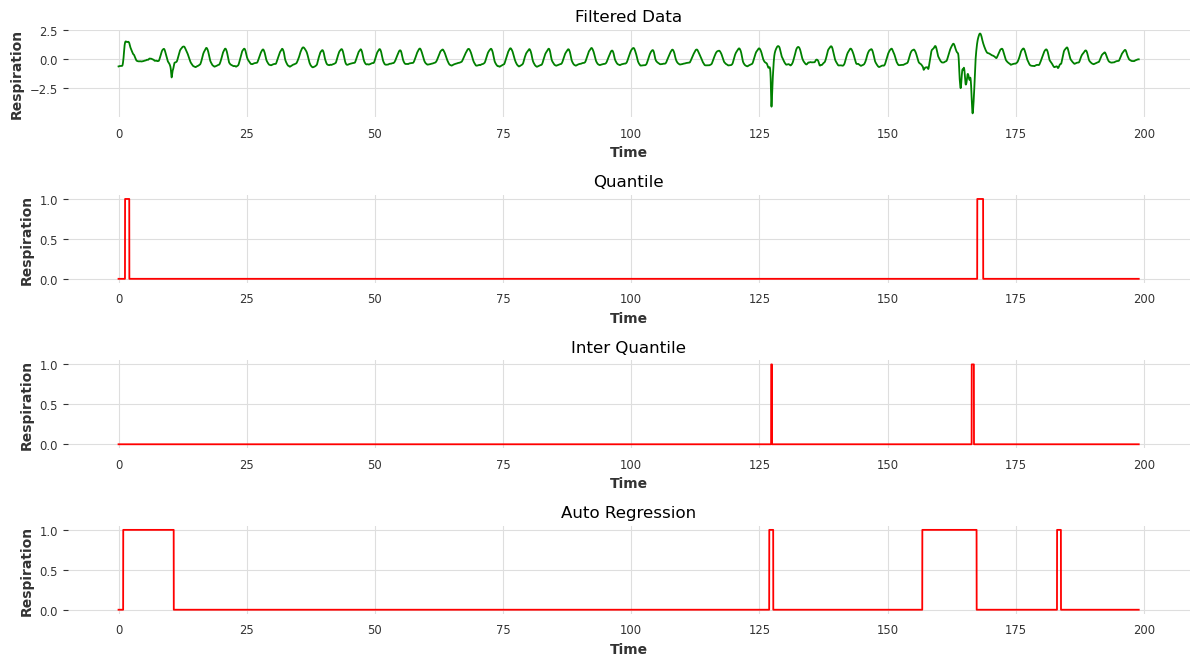

[0 0 0 ... 0 0 0]


In [87]:
path = r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\01\1_01-02-01.csv'
filtResp2 = pd.read_csv(path)
y_mask, df_detected = anomaly_det(filtResp2, verbose=True, AD_c=4, AD_side="both", AD_n_steps=3, AD_step_size=50, Return_vals = True)
print(y_mask)

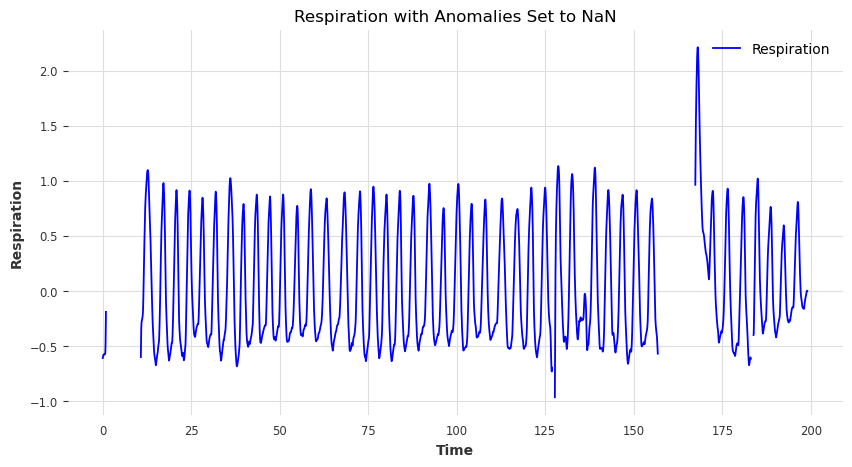

In [88]:
mask = y_mask.astype(bool)
filtResp2.loc[mask, 'Respiration'] = np.nan
plt.figure(figsize=(10, 5))
plt.plot(filtResp2['Time'], filtResp2['Respiration'], 'b-', label="Respiration")
plt.title("Respiration with Anomalies Set to NaN")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.savefig(r'D:\Thesis Data\Thesis Data\RepirationToolKit\respiration_AnomaliesRemoved.png', bbox_inches='tight')
plt.show()

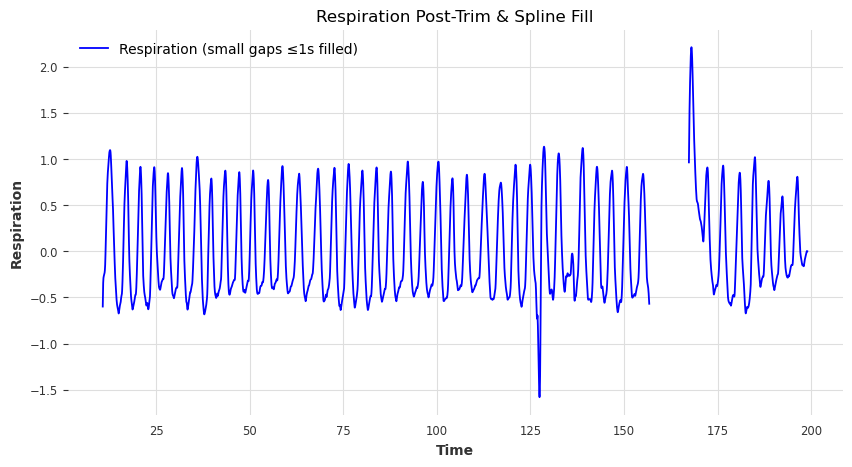

In [89]:
# ── 0) Sort & reset
filtResp2 = filtResp2.sort_values('Time').reset_index(drop=True)

# ── NEW: trim any NaNs within the first 5 seconds ──
mask_nan = filtResp2['Respiration'].isna()
# indices of all NaNs
nan_all = np.where(mask_nan)[0]
if nan_all.size > 0:
    # identify contiguous NaN runs
    runs_all = np.split(nan_all, np.where(np.diff(nan_all) != 1)[0] + 1)
    # consider only runs starting within first 5s
    first_window_idx = filtResp2.index[filtResp2['Time'] <= 5].max()
    for run in runs_all:
        if run[0] <= first_window_idx:
            end_idx = run[-1]
            # drop everything up to and including that NaN run
            filtResp2 = filtResp2.iloc[end_idx+1:].reset_index(drop=True)
            break

# ── 1) Fit spline on remaining “good” points ──
mask_valid = ~filtResp2['Respiration'].isna()
x = filtResp2.loc[mask_valid, 'Time']
y = filtResp2.loc[mask_valid, 'Respiration']
spline = UnivariateSpline(x, y, s=1, k=3)

# ── 2) Identify new contiguous NaN runs ──
mask_nan = filtResp2['Respiration'].isna().values
nan_idxs = np.where(mask_nan)[0]
runs = np.split(nan_idxs, np.where(np.diff(nan_idxs) != 1)[0] + 1)

# ── 3) Fill only the runs shorter than 1 second ──
for run in runs:
    if run.size == 0:
        continue
    start_idx, end_idx = run[0], run[-1]
    gap_duration = filtResp2.loc[end_idx, 'Time'] - filtResp2.loc[start_idx, 'Time']
    if gap_duration <= 1.0:
        times = filtResp2.loc[run, 'Time']
        filtResp2.loc[run, 'Respiration'] = spline(times)

# ── 4) Plot ──
plt.figure(figsize=(10, 5))
plt.plot(filtResp2['Time'], filtResp2['Respiration'], 'b-', label="Respiration (small gaps ≤1s filled)")
plt.title("Respiration Post-Trim & Spline Fill")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.savefig(r'D:\Thesis Data\Thesis Data\RepirationToolKit\respiration_SplineInterpolation.png', bbox_inches='tight')
plt.show()

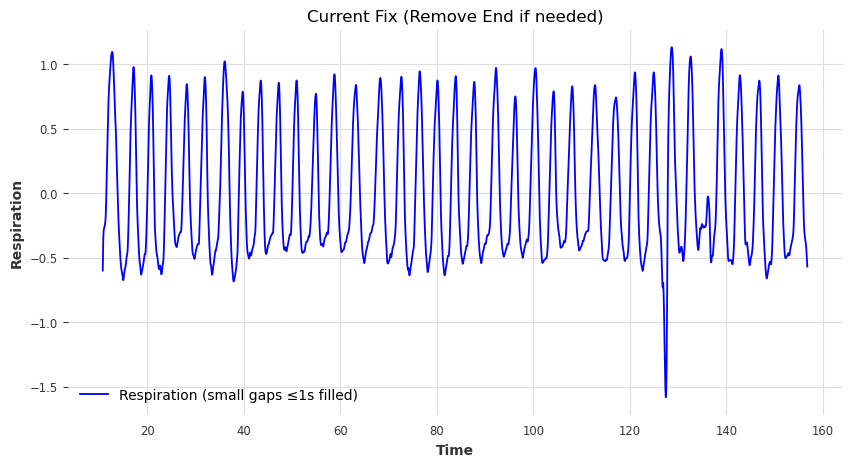

In [82]:
# Assume filtResp2 already exists in your namespace
nan_indices = filtResp2.index[filtResp2['Respiration'].isna()]

if len(nan_indices) > 0:
    # Find the position of the first NaN
    first_nan_idx = nan_indices[0]
    # Keep only rows before the first NaN
    filtResp2 = filtResp2.iloc[:first_nan_idx].reset_index(drop=True)

# filtResp2 now has all rows trimmed from the first NaN onward
plt.figure(figsize=(10, 5))
plt.plot(filtResp2['Time'], filtResp2['Respiration'], 'b-', label="Respiration (small gaps ≤1s filled)")
plt.title("Current Fix (Remove End if needed)")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.savefig(r'D:\Thesis Data\Thesis Data\RepirationToolKit\respiration_removed.png', bbox_inches='tight')
plt.show()

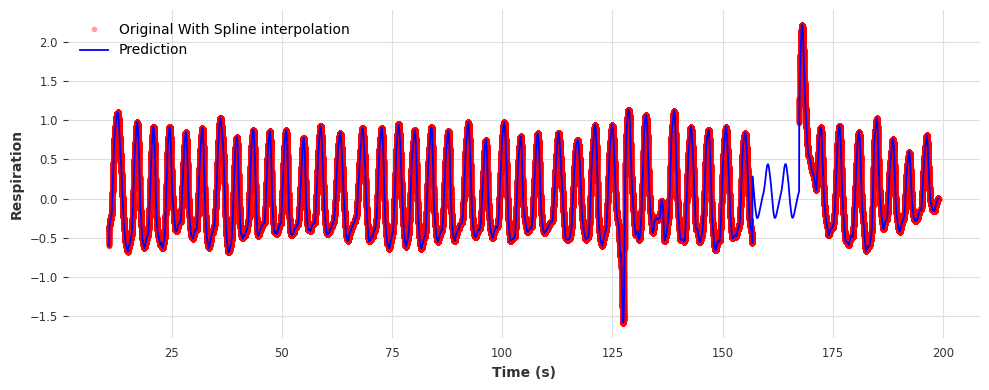

In [91]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# 1) Load your data (with NaNs already marked)
filt = filtResp2.sort_values('Time').reset_index(drop=True)
t = filt['Time'].values
y = filt['Respiration'].values

# 2) Build Fourier features
P = 4.0           # breathing period (s)
K = 8             # number of harmonics
# design matrix: [sin(2πk t/P), cos(2πk t/P)] for k=1..K
X = np.column_stack([
    np.sin(2 * np.pi * k * t / P) for k in range(1, K+1)
] + [
    np.cos(2 * np.pi * k * t / P) for k in range(1, K+1)
])
# optional trend term
X = np.column_stack([X, t])

# 3) Fit Ridge on the *observed* (non‑NaN) rows
mask_obs = ~np.isnan(y)
model = Ridge(alpha=1.0)  # adjust regularization as needed
model.fit(X[mask_obs], y[mask_obs])

# 4) Predict at *all* timestamps
y_pred = model.predict(X)

# 5) Splice back: keep original where present, else use the prediction
y_filled = y.copy()
y_filled[np.isnan(y)] = y_pred[np.isnan(y)]

# 6) Plot
plt.figure(figsize=(10,4))
plt.plot(t, y,       'r.', alpha=0.3, label="Original With Spline interpolation")
plt.plot(t, y_filled,'b-',            label="Prediction")
plt.legend(); plt.xlabel("Time (s)"); plt.ylabel("Respiration")
plt.tight_layout()
plt.show()

In [ ]:
# Ensure DataFrame is sorted by Time
filtResp2 = filtResp2.sort_values('Time').reset_index(drop=True)

# Fit spline using non-NaN values
mask_valid = ~filtResp2['Respiration'].isna()
x = filtResp2.loc[mask_valid, 'Time']
y = filtResp2.loc[mask_valid, 'Respiration']

spline = UnivariateSpline(x, y, s=2, k=4)

# Overwrite the "Respiration" column with interpolated values
filtResp2['Respiration'] = spline(filtResp2['Time'])

plt.figure(figsize=(10, 5))
plt.plot(filtResp2['Time'], filtResp2['Respiration'], 'b-', label="Respiration Interpolated")
plt.title("Respiration with Anomalies Fixed via Spline")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.show()

Fitting Detectors...
Intervals from AD_Format:
Interval: (0.897, 10.7555)
Interval: (126.9055, 127.6865)
Interval: (156.76, 167.356)
Interval: (183.0415, 183.803)


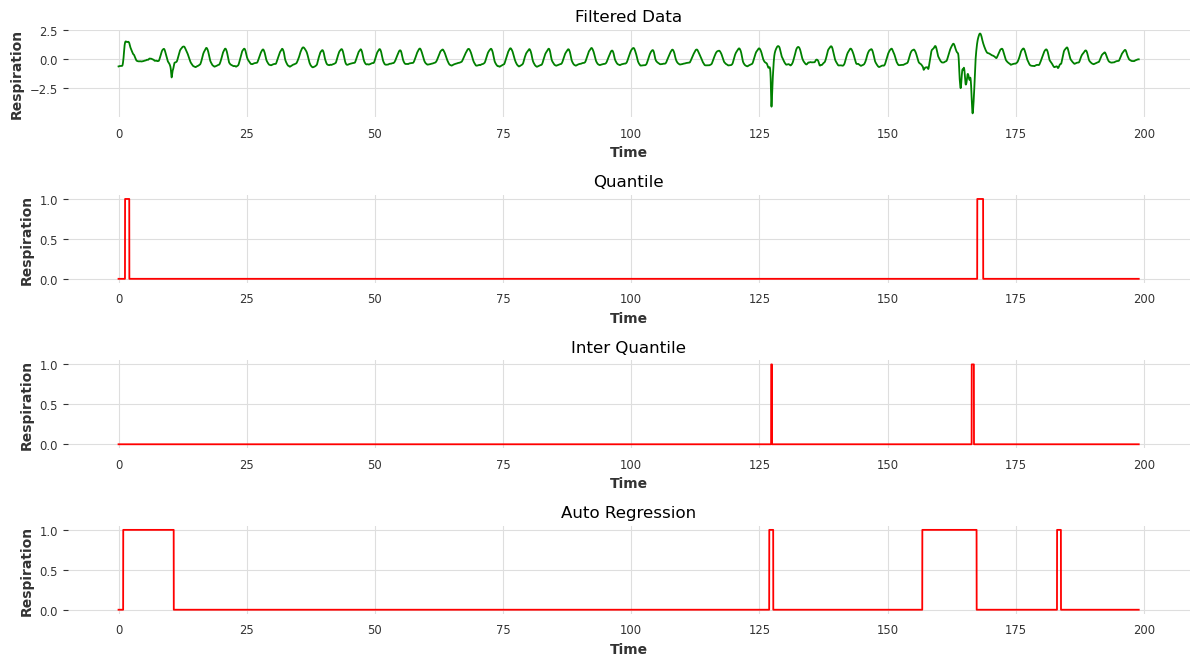

ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='500us'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases


ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='500us'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1) Sort & reset
filtResp2 = filtResp2.sort_values('Time').reset_index(drop=True)
y = filtResp2['Respiration']

# 2) Fit HWES with multiplicative seasonality and an additive, damped trend
s = 17  # 17 cycles per minute
model = ExponentialSmoothing(
    y,
    trend='add',
    damped_trend=True,
    seasonal='mul',
    seasonal_periods=s,
    initialization_method='estimated'
)
fit = model.fit(optimized=True)

# 3) Extract the in‑sample fitted values
fitted = fit.fittedvalues  # state‑space smoothed series :contentReference[oaicite:0]{index=0}

# 4) Fill only the NaN gaps
resp_filled = y.copy()
mask_nan = resp_filled.isna()
resp_filled[mask_nan] = fitted[mask_nan]

# 5) Overwrite & plot
filtResp2['Respiration'] = resp_filled

plt.figure(figsize=(10,5))
plt.plot(filtResp2['Time'], filtResp2['Respiration'], label='Trend+Mul‑Season ETS')
plt.title("Respiration with Multiplicative‑Seasonal ETS Imputation")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.show()


In [161]:
import pmdarima as pm

# Try candidate seasonal periods from 2 to 30 and choose the best model
best_model = None
best_aic = float('inf')
best_m = None

for m in range(2, 31):
    print(f"Iteration {m}")
    try:
        model = pm.auto_arima(
            filtResp2['Respiration'], 
            seasonal=True, 
            m=m,         # candidate seasonal period
            trace=False, 
            error_action='ignore', 
            suppress_warnings=True, 
            stepwise=True
        )
        if model.aic() < best_aic:
            best_aic = model.aic()
            best_model = model
            best_m = m
            print(f"Changed Seasonal Period to {best_m}")
    except Exception as e:
        # Continue if the model fails for a given m
        continue

print("Selected seasonal period:", best_m)
print(best_model.summary())


Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Selected seasonal period: None


AttributeError: 'NoneType' object has no attribute 'summary'

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\01\1_01-02-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.8565, 10.7145)
Interval: (126.8665, 127.552)
Interval: (156.7275, 167.2025)
Interval: (183.065, 183.7665)
Starting Hampel Eval...
Hampel Fitting done...


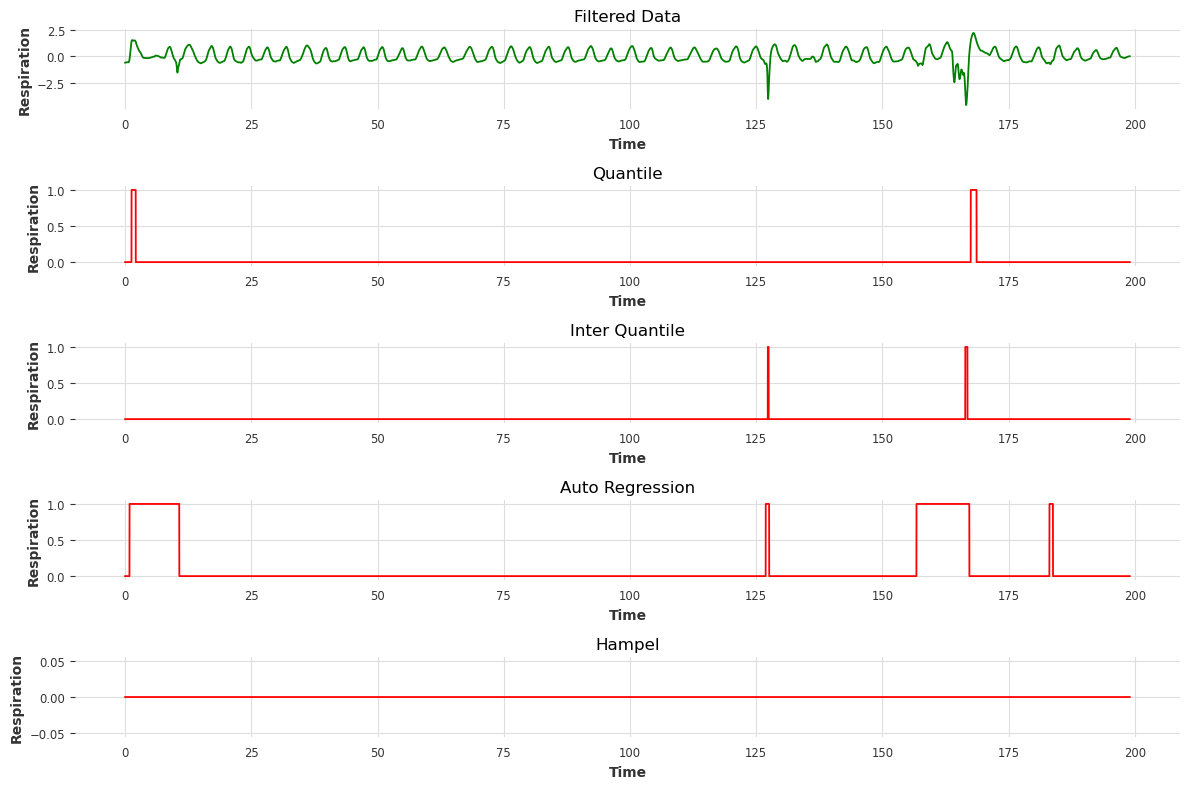

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\01\1_01-04-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.366, 28.6665)
Interval: (48.161, 53.917)
Interval: (94.7985, 96.2335)
Interval: (142.3365, 148.20850000000002)
Starting Hampel Eval...
Hampel Fitting done...


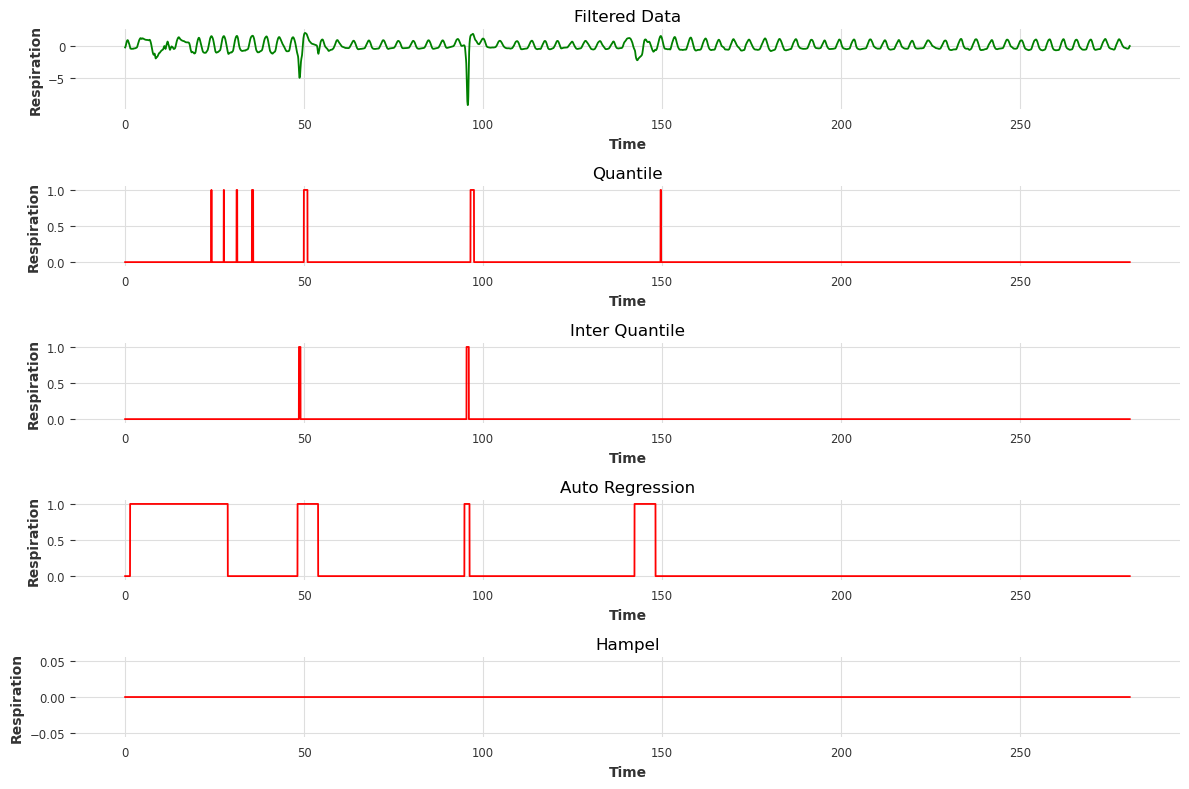

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\04\1_04-01-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.015, 20.439)
Interval: (70.7025, 73.8645)
Interval: (85.4315, 85.46900000000001)
Starting Hampel Eval...
Hampel Fitting done...


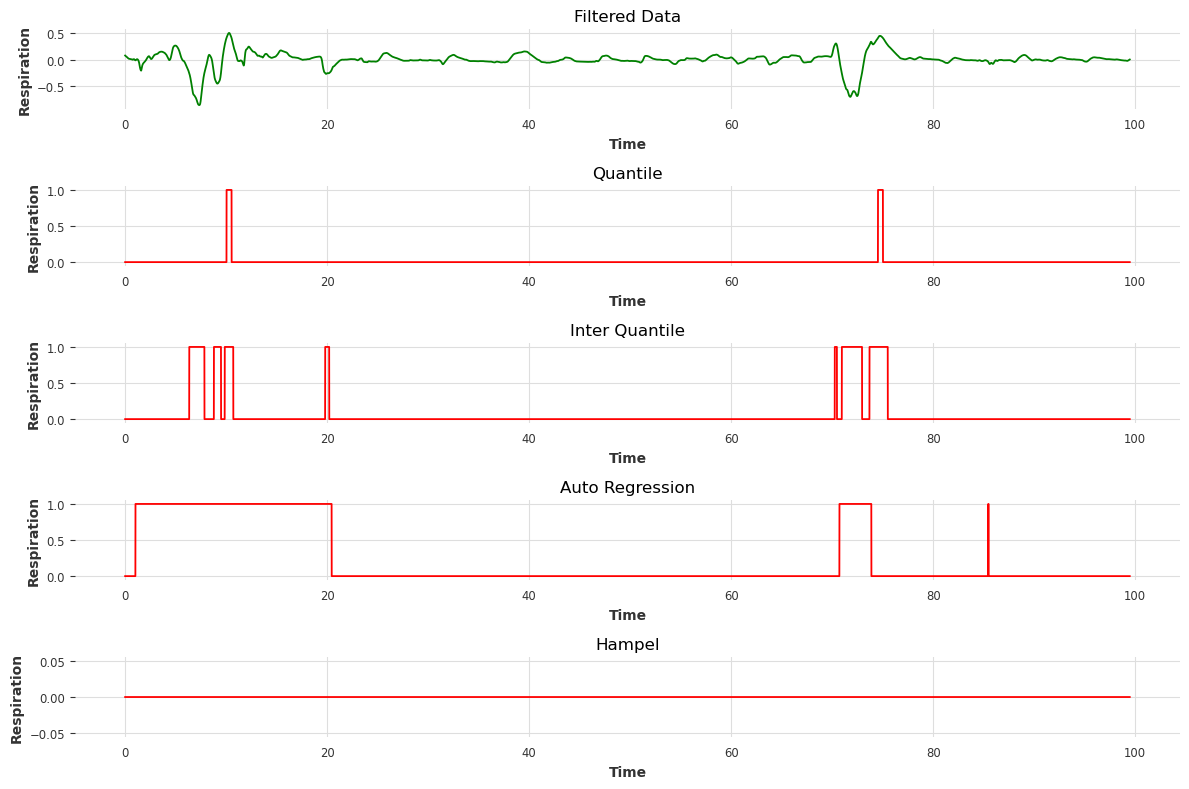

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\04\1_04-01-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.6575, 11.273)
Interval: (25.7645, 25.874)
Interval: (36.68, 47.1575)
Interval: (70.88550000000001, 91.5105)
Interval: (124.5935, 137.891)
Interval: (160.9385, 161.512)
Starting Hampel Eval...
Hampel Fitting done...


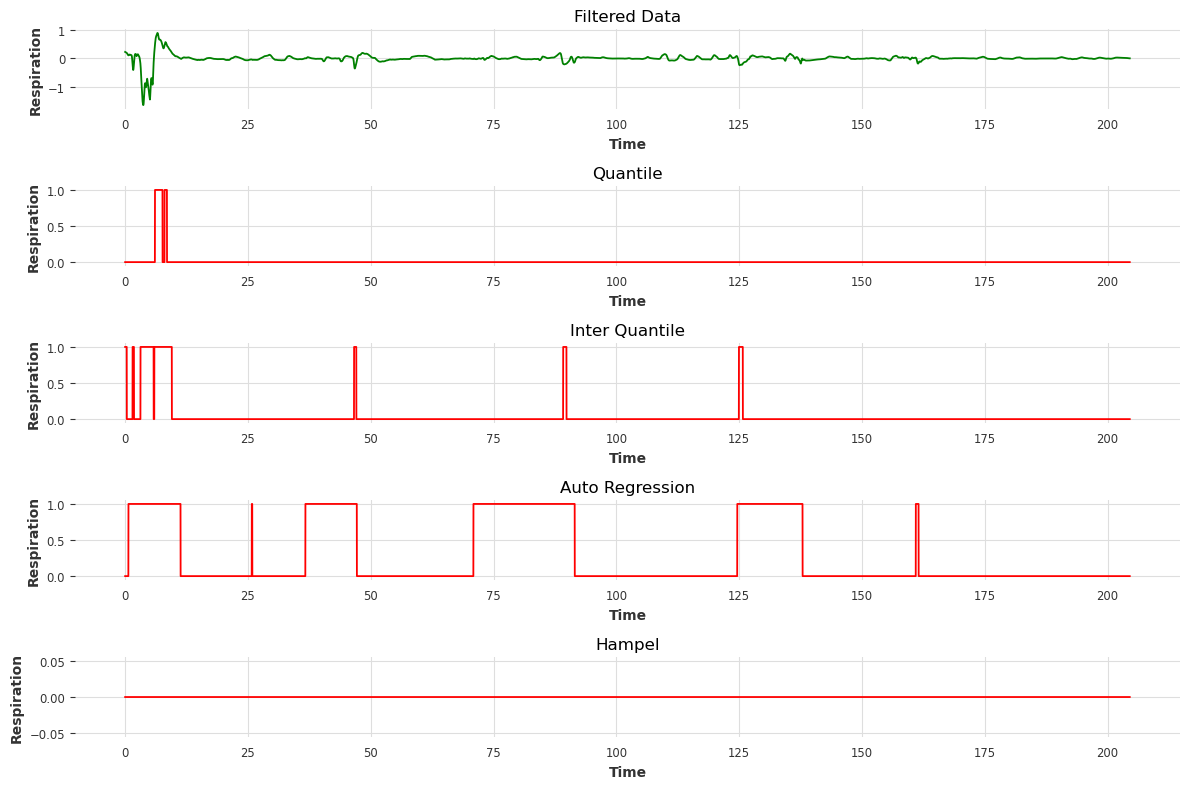

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\04\1_04-05-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (32.983000000000004, 36.3705)
Interval: (69.7085, 77.923)
Interval: (120.2125, 148.701)
Interval: (174.516, 175.4795)
Interval: (210.4145, 220.1465)
Starting Hampel Eval...
Hampel Fitting done...


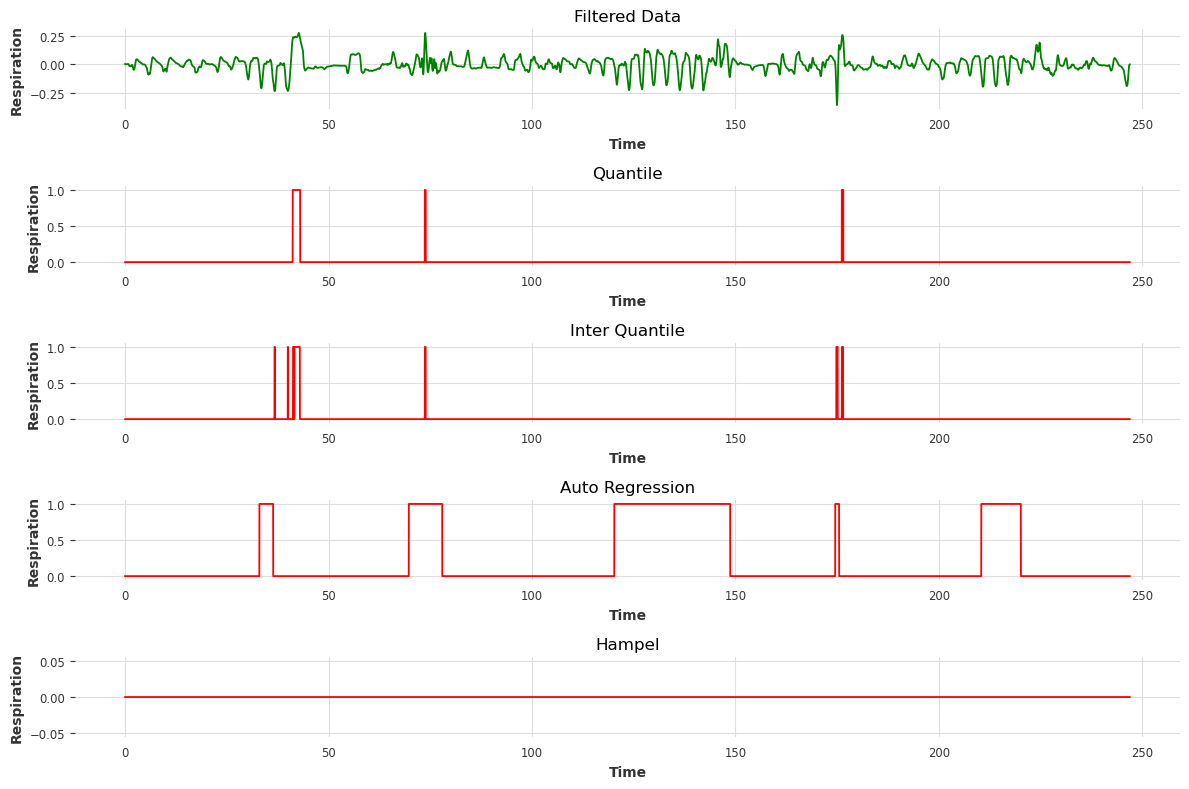

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\04\1_04-07-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (8.56, 29.376)
Starting Hampel Eval...
Hampel Fitting done...


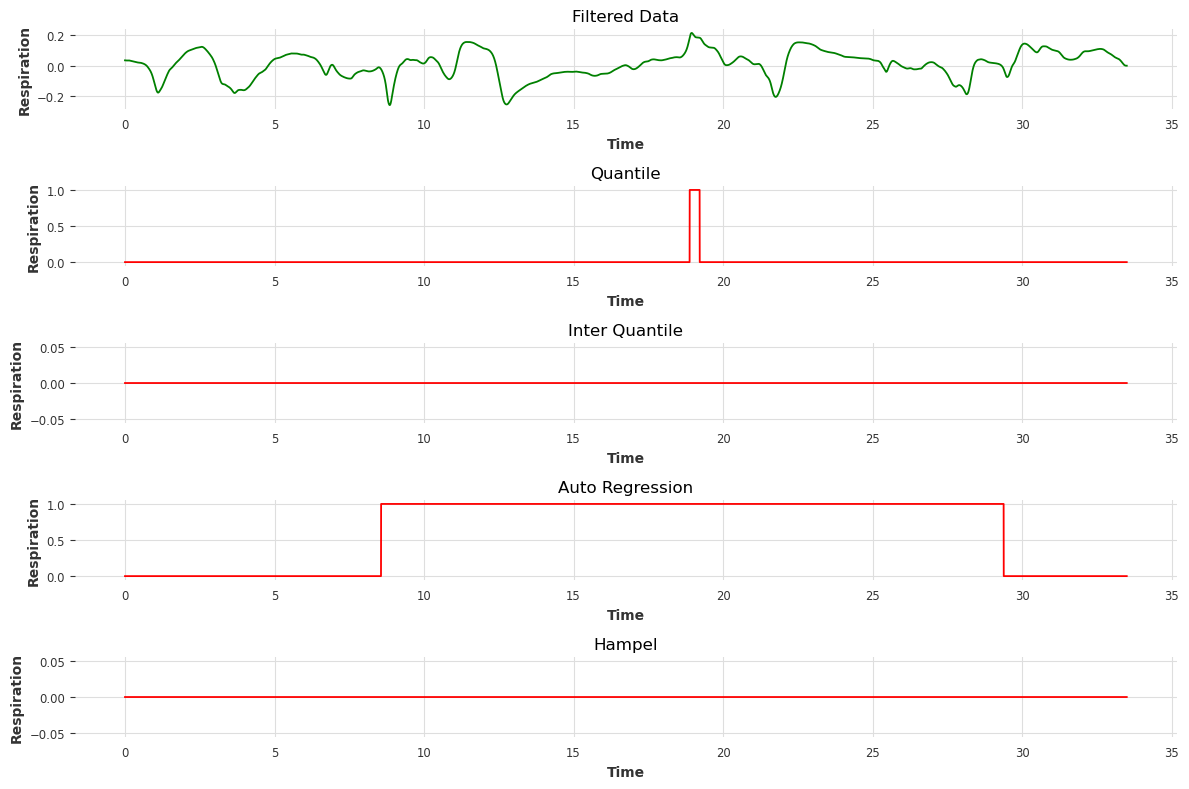

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\05\1_05-01-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.146, 56.874500000000005)
Starting Hampel Eval...
Hampel Fitting done...


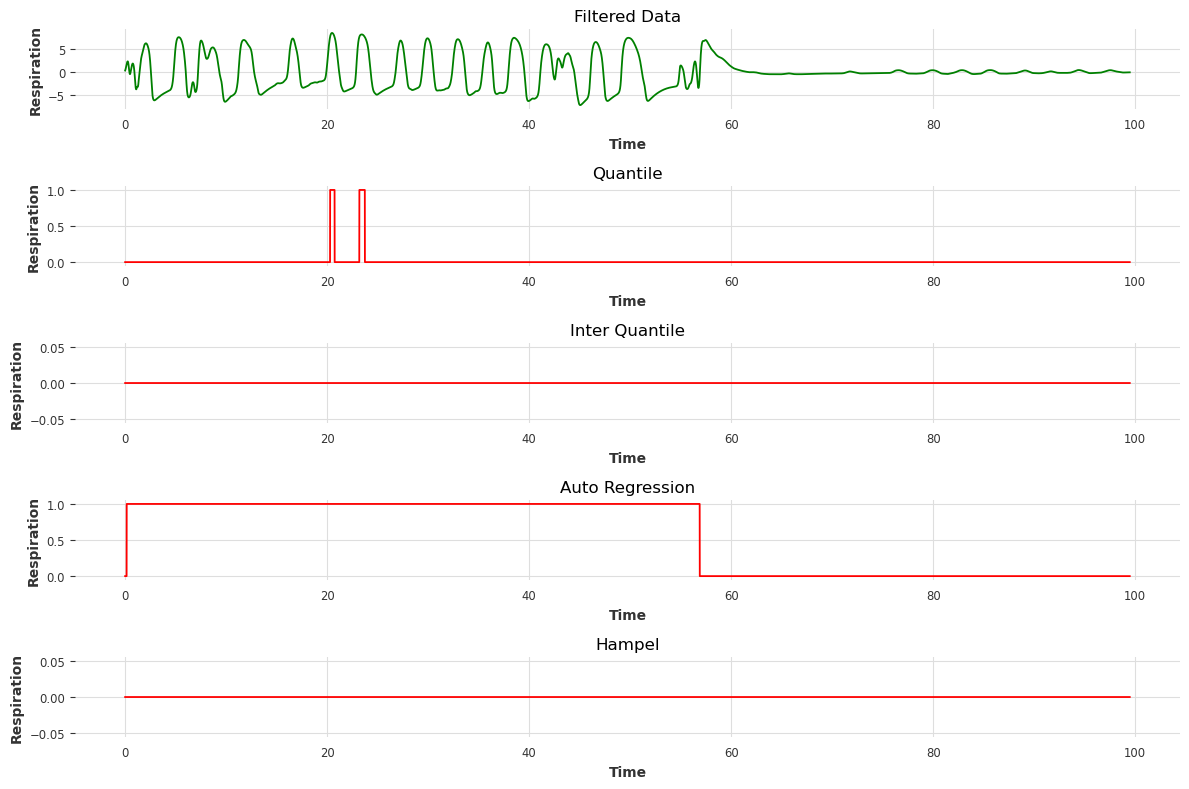

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\05\1_05-01-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.0095, 1.4325)
Interval: (25.109, 25.864)
Interval: (176.9555, 204.3325)
Starting Hampel Eval...
Hampel Fitting done...


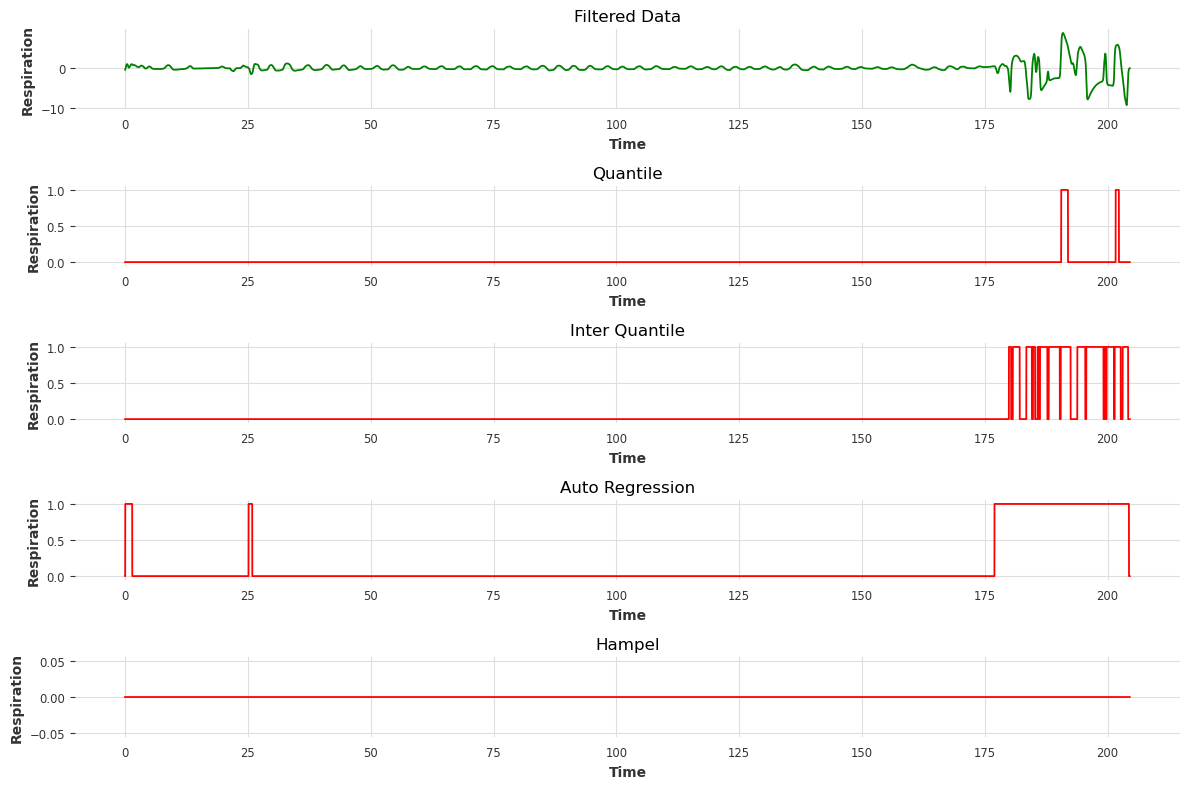

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\05\1_05-03-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.271, 48.5335)
Interval: (163.383, 167.13750000000002)
Interval: (189.447, 199.2705)
Interval: (287.224, 287.6595)
Interval: (356.891, 357.82)
Starting Hampel Eval...
Hampel Fitting done...


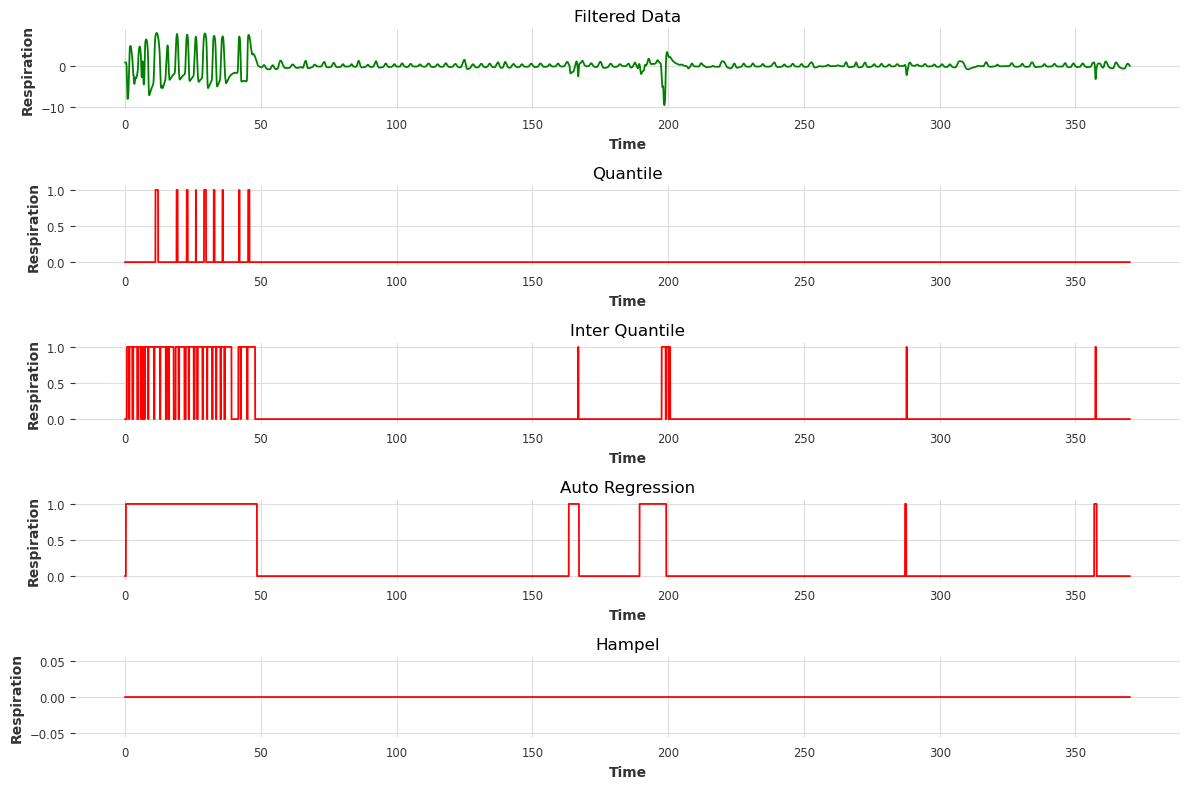

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\07\1_07-01-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.7315, 1.26)
Interval: (29.923, 32.863)
Interval: (50.1155, 50.2845)
Interval: (61.24, 61.806)
Interval: (85.129, 92.017)
Starting Hampel Eval...
Hampel Fitting done...


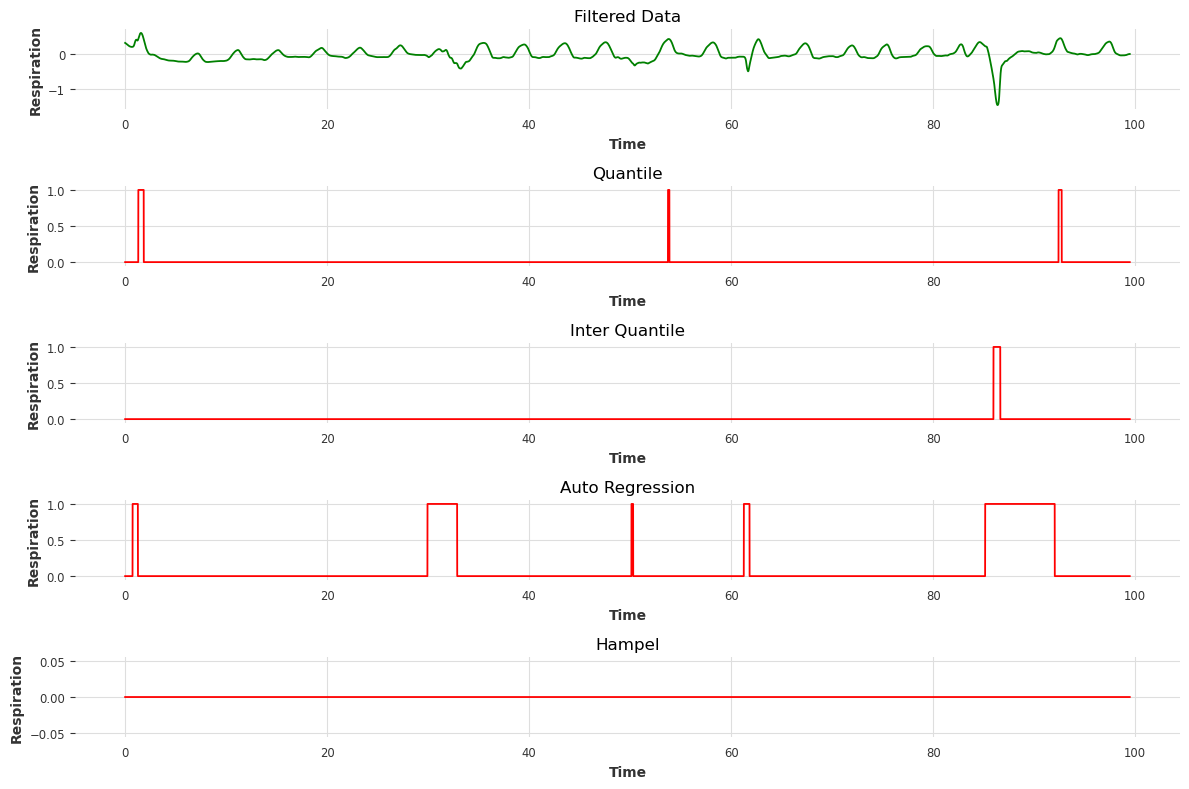

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\07\1_07-01-04.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.9425, 11.7125)
Interval: (53.4975, 60.6525)
Starting Hampel Eval...
Hampel Fitting done...


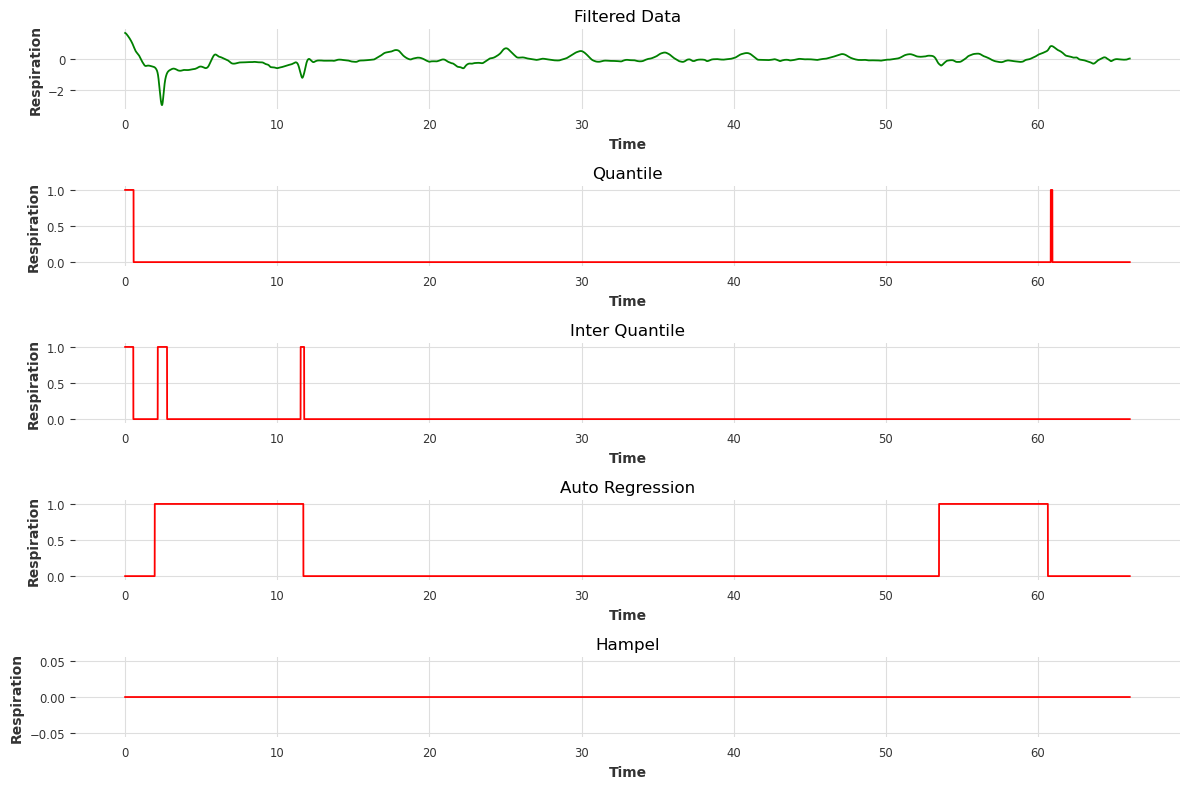

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\07\1_07-01-05.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.091, 4.658)
Interval: (46.9625, 54.5815)
Starting Hampel Eval...
Hampel Fitting done...


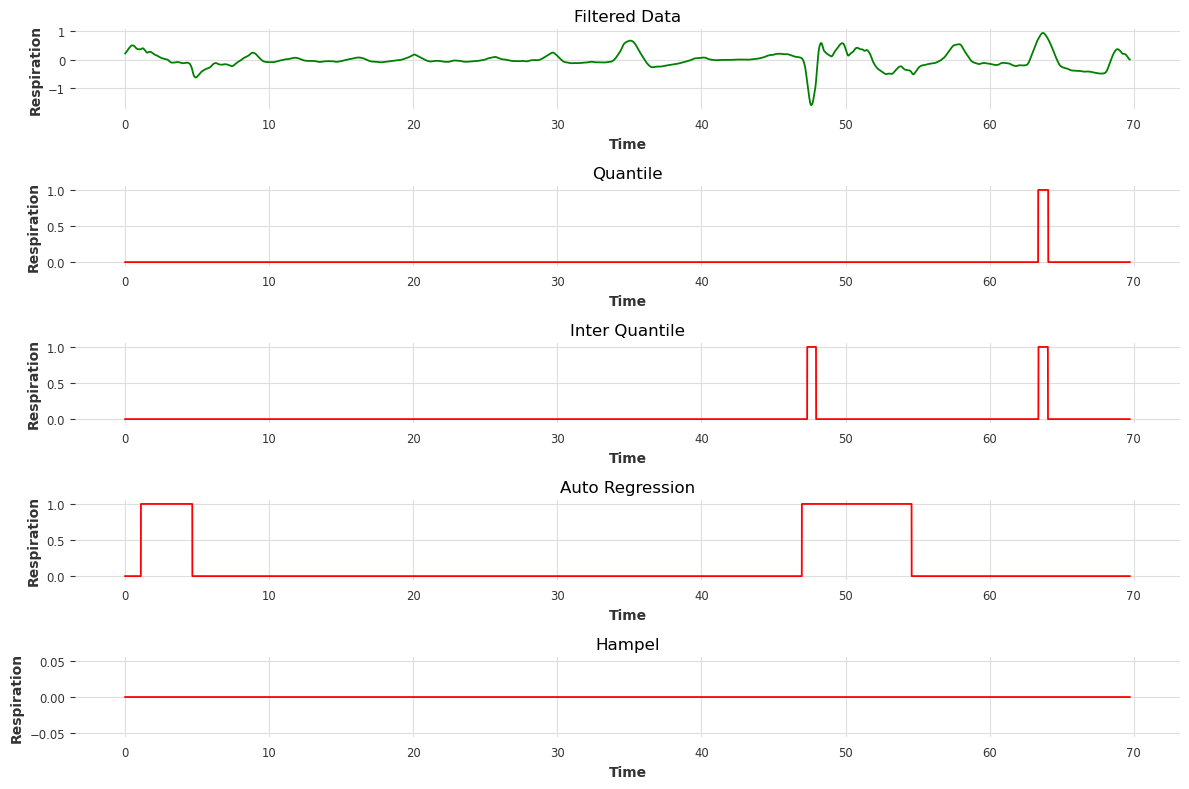

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\07\1_07-02-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.0005, 22.685)
Interval: (56.345, 70.94)
Starting Hampel Eval...
Hampel Fitting done...


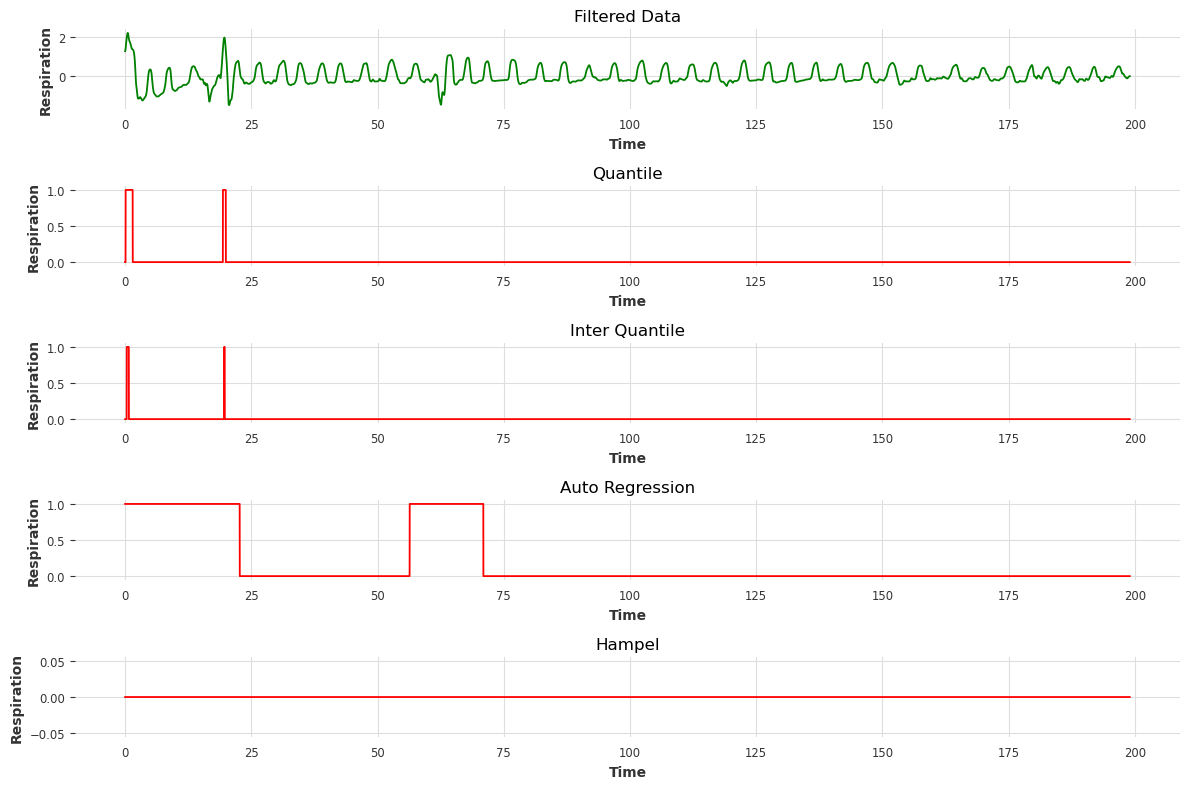

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\08\1_08-01-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.0895, 32.3295)
Starting Hampel Eval...
Hampel Fitting done...


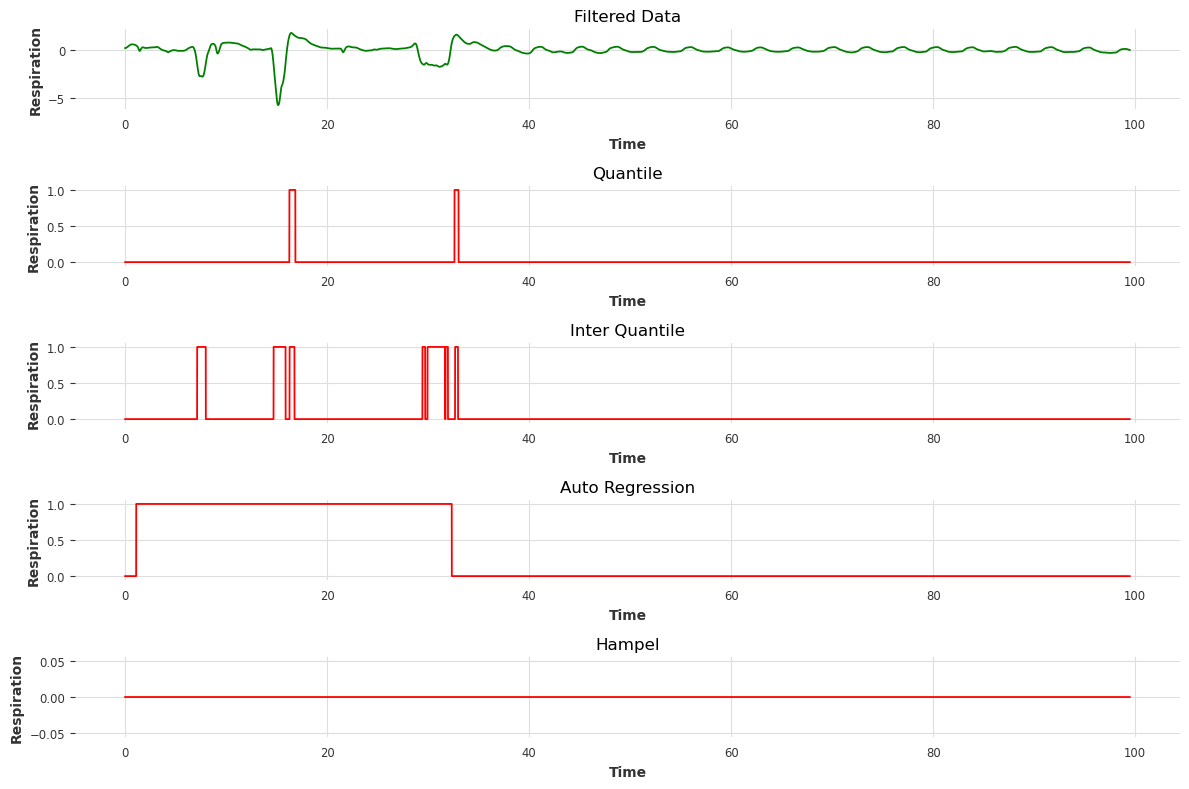

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\08\1_08-01-04.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.0005, 0.6975)
Interval: (11.535, 11.995)
Starting Hampel Eval...
Hampel Fitting done...


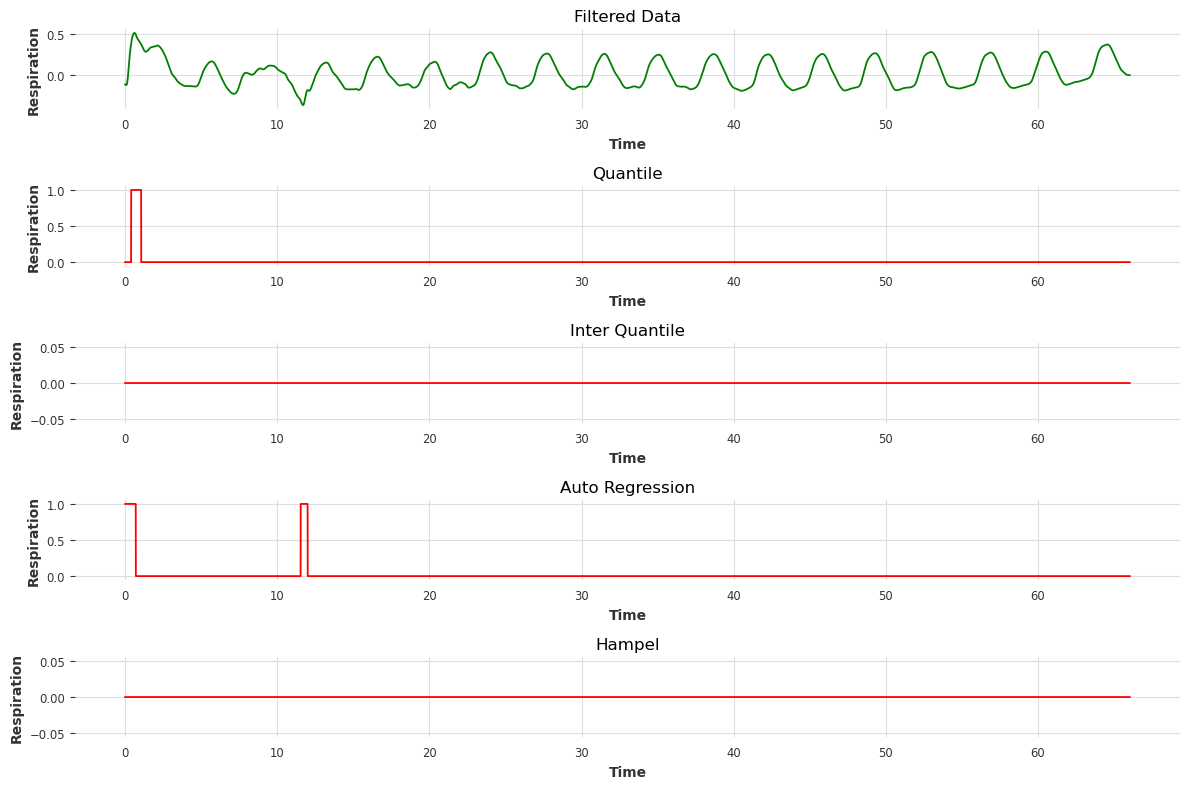

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\08\1_08-01-05.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (4.0305, 4.1505)
Interval: (53.4665, 58.941)
Starting Hampel Eval...
Hampel Fitting done...


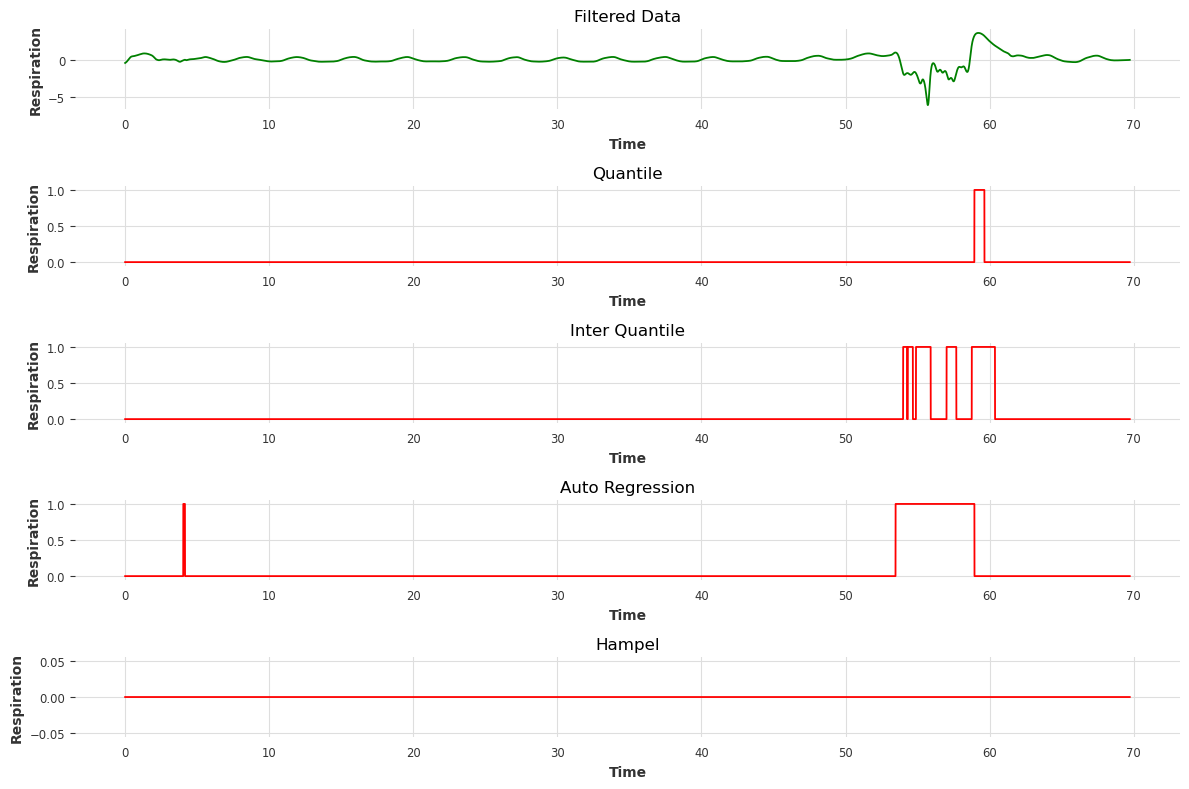

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\08\1_08-04-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.0005, 8.45)
Interval: (54.7335, 59.271)
Starting Hampel Eval...
Hampel Fitting done...


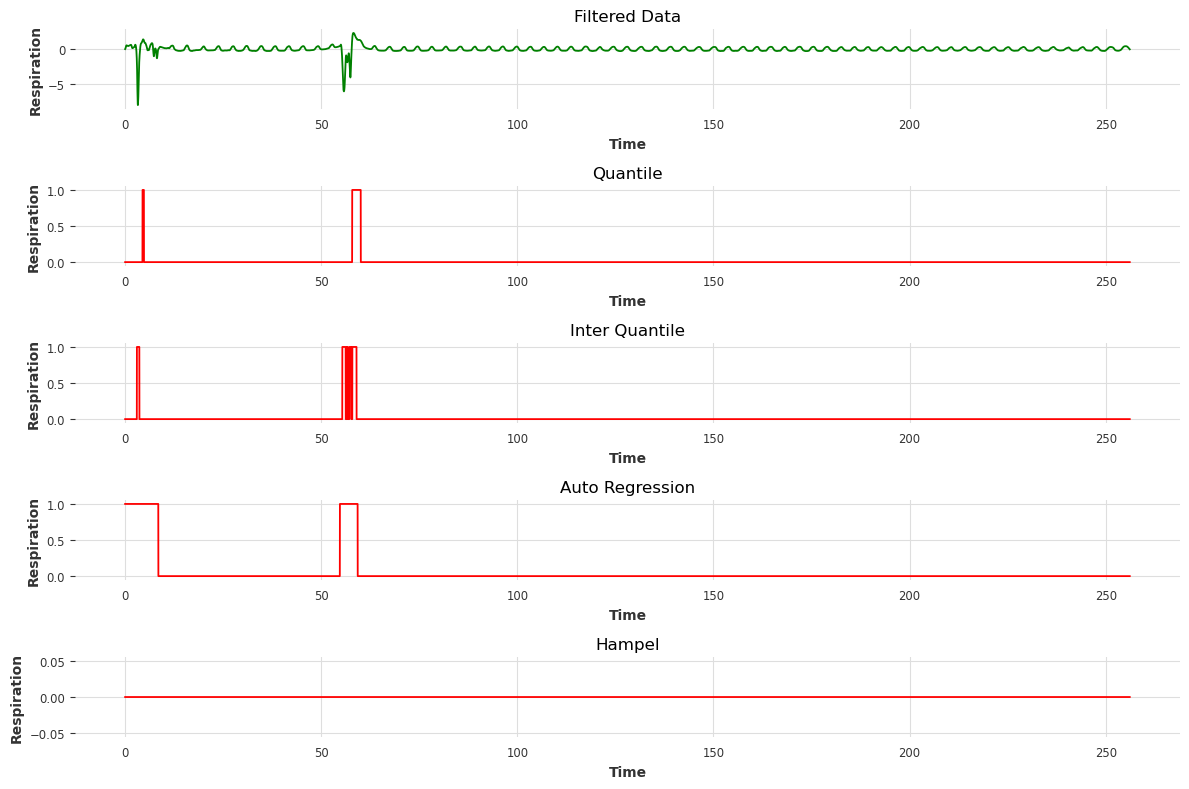

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\08\1_08-05-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.346, 1.851)
Interval: (222.266, 225.9675)
Starting Hampel Eval...
Hampel Fitting done...


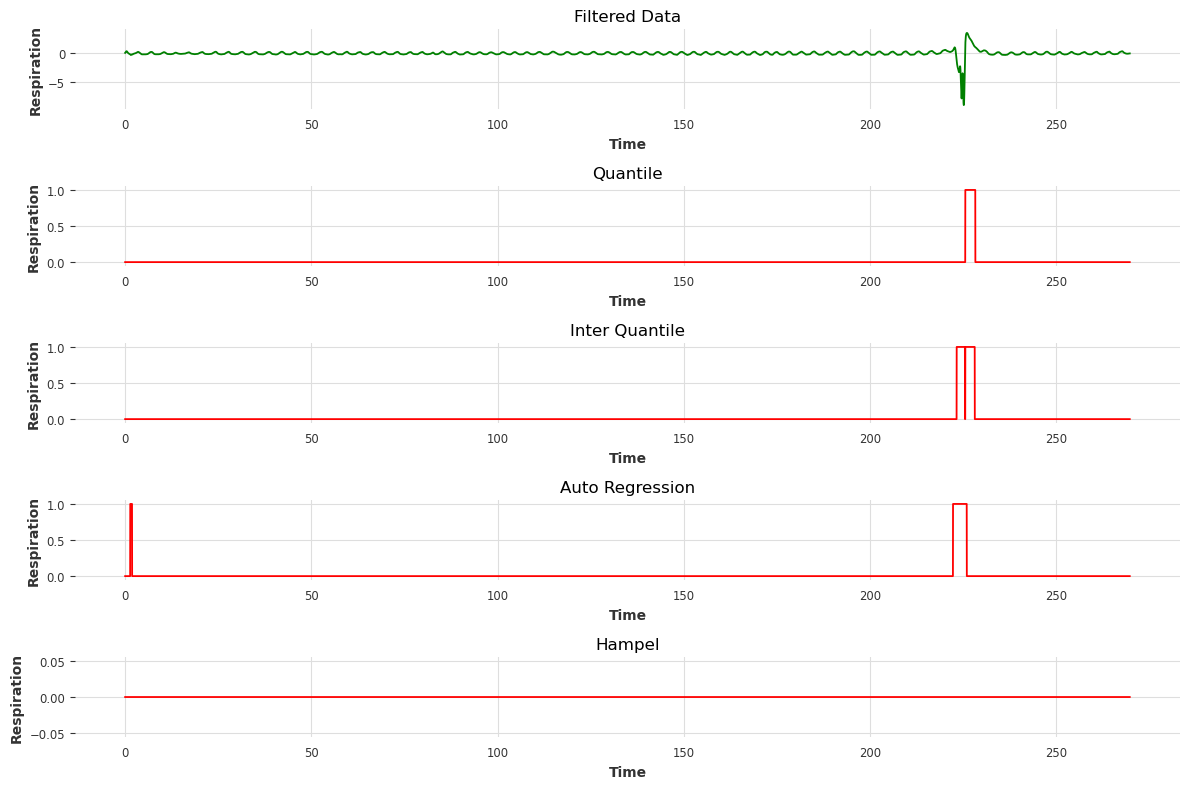

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\08\1_08-07-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (3.1315, 3.277)
Interval: (55.1655, 55.5165)
Interval: (72.5855, 85.2745)
Starting Hampel Eval...
Hampel Fitting done...


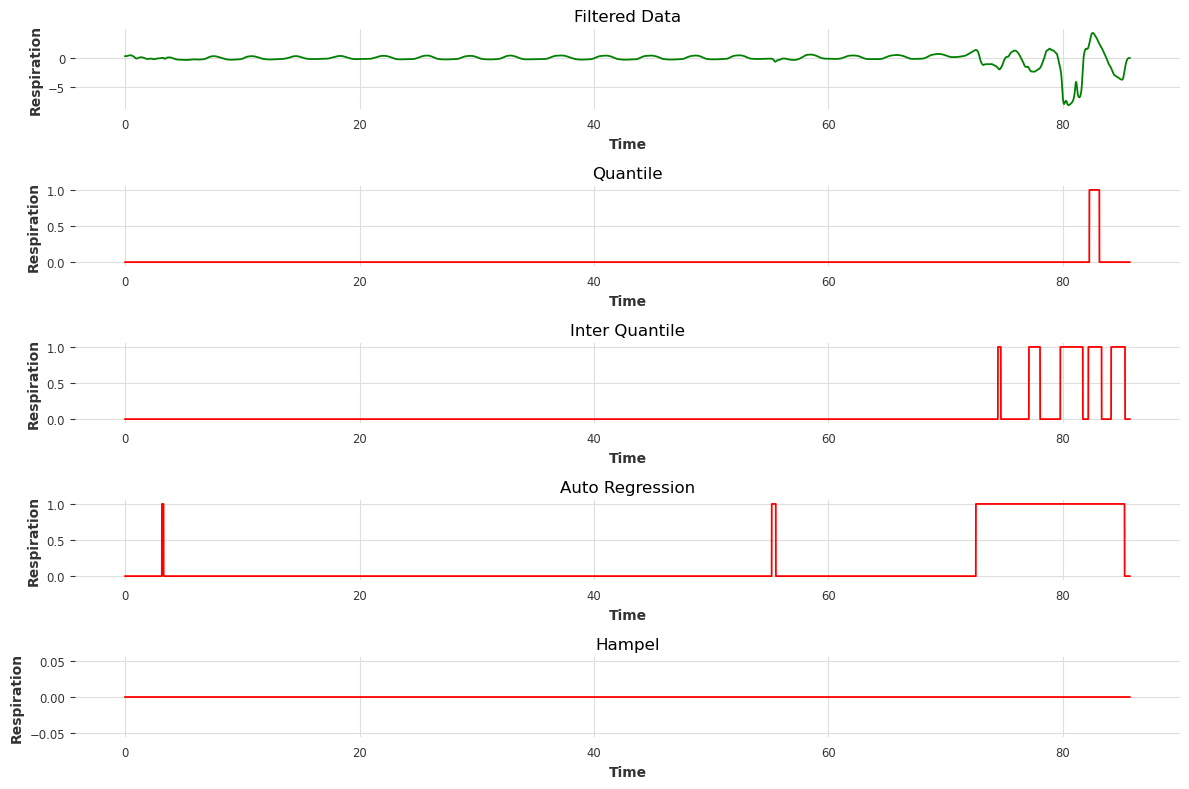

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\11\1_11-01-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.2345, 27.545)
Interval: (126.535, 130.40800000000002)
Starting Hampel Eval...
Hampel Fitting done...


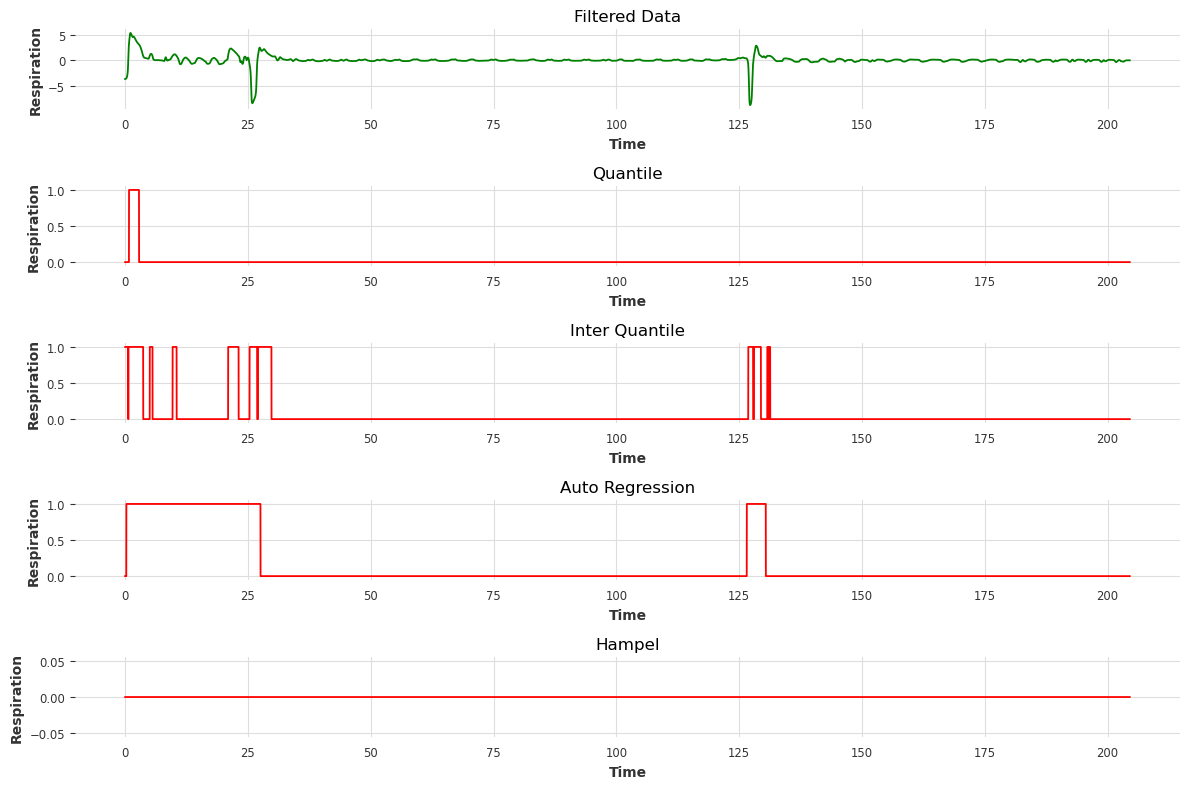

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\11\1_11-02-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.3385, 6.0045)
Interval: (29.434, 44.165)
Interval: (69.34, 69.397)
Starting Hampel Eval...
Hampel Fitting done...


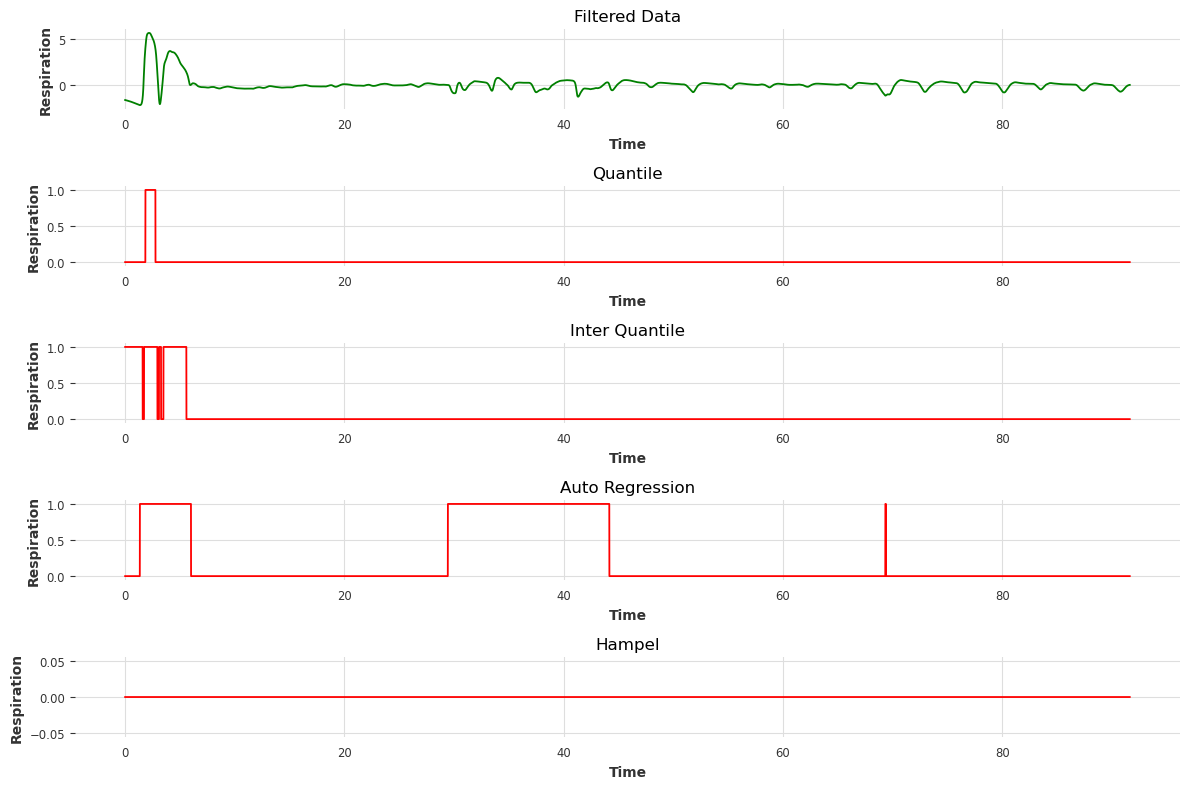

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\11\1_11-07-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (26.8615, 47.7725)
Interval: (58.6475, 79.2095)
Starting Hampel Eval...
Hampel Fitting done...


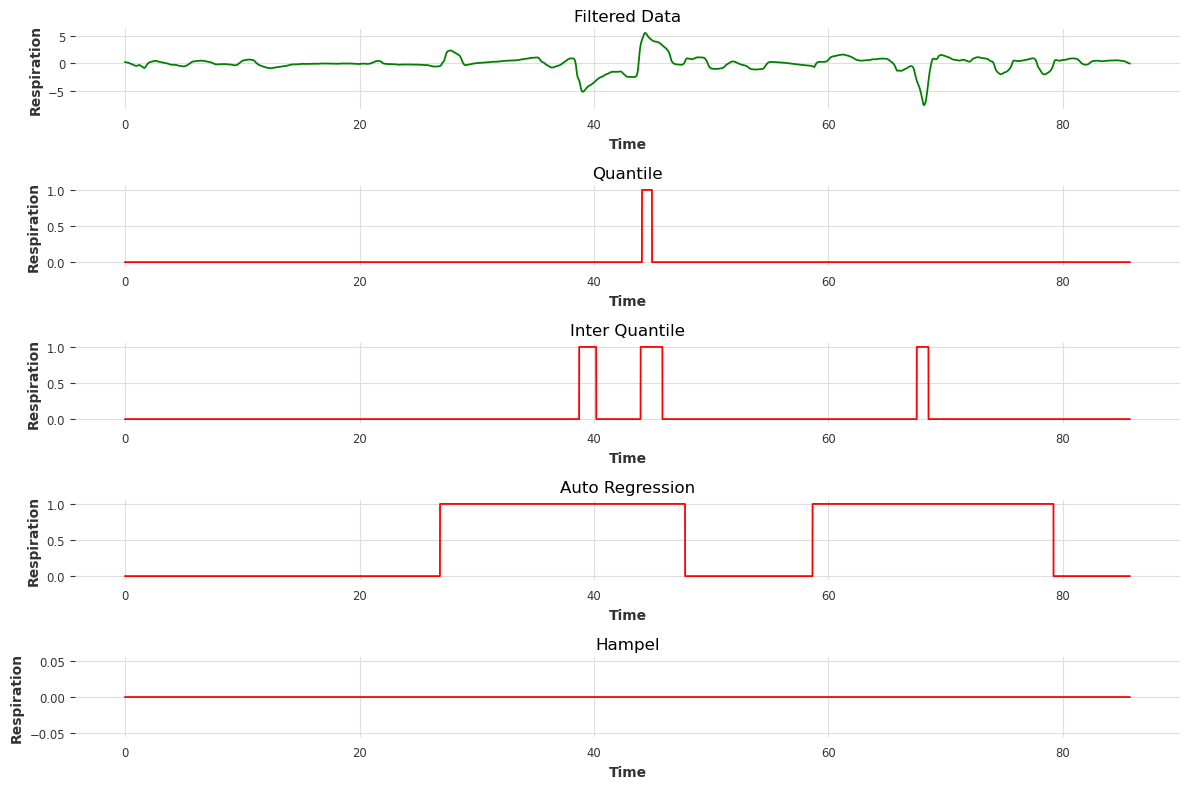

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\13\1_13-06-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.441, 73.1755)
Interval: (83.2225, 107.94)
Interval: (157.425, 159.9285)
Starting Hampel Eval...
Hampel Fitting done...


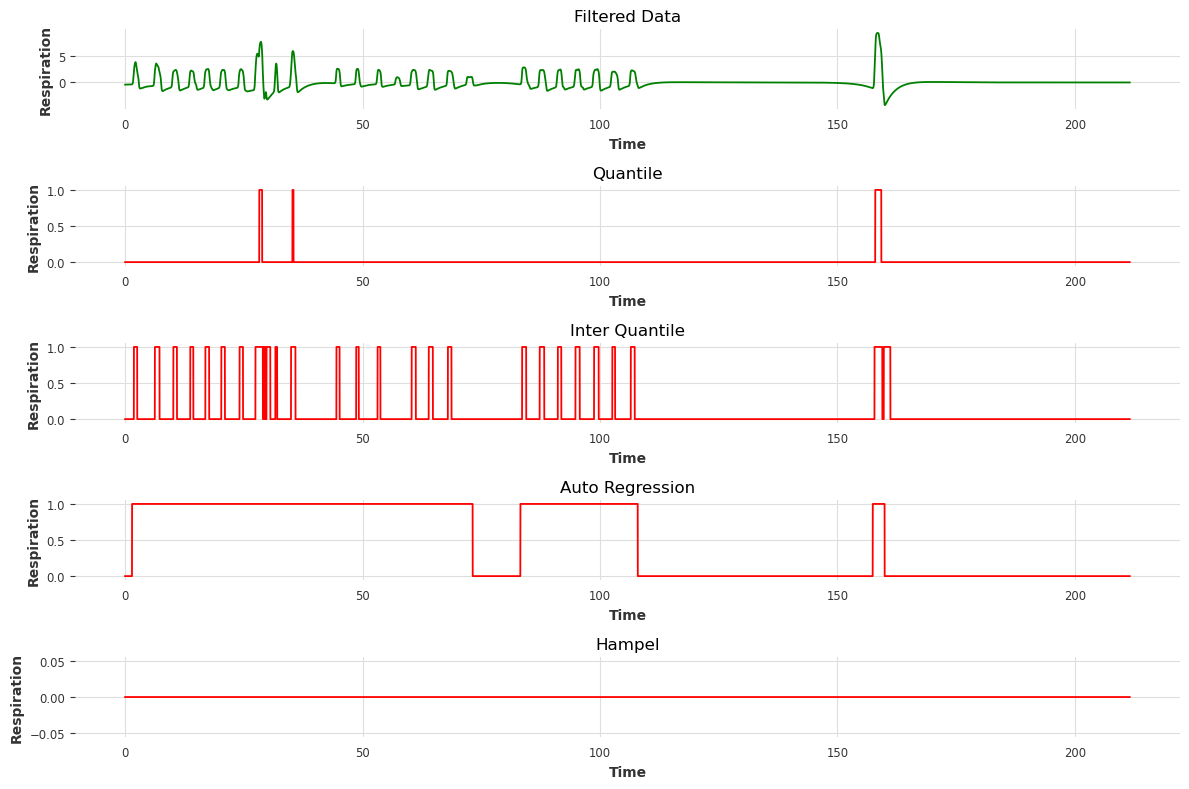

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\14\1_14-05-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (77.8385, 82.8655)
Interval: (111.9955, 114.12)
Starting Hampel Eval...
Hampel Fitting done...


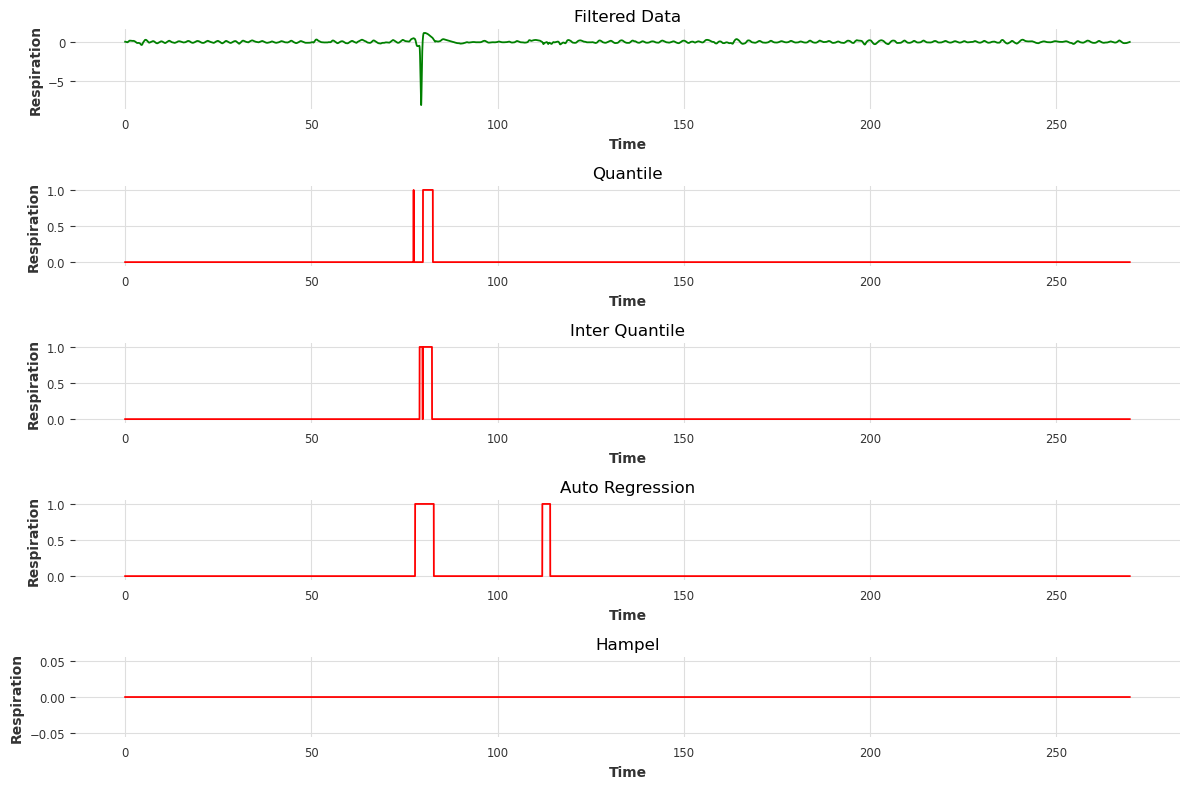

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\17\1_17-01-02.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.0005, 13.1415)
Interval: (43.912, 50.4915)
Interval: (76.58200000000001, 77.9175)
Interval: (157.1055, 162.9685)
Starting Hampel Eval...
Hampel Fitting done...


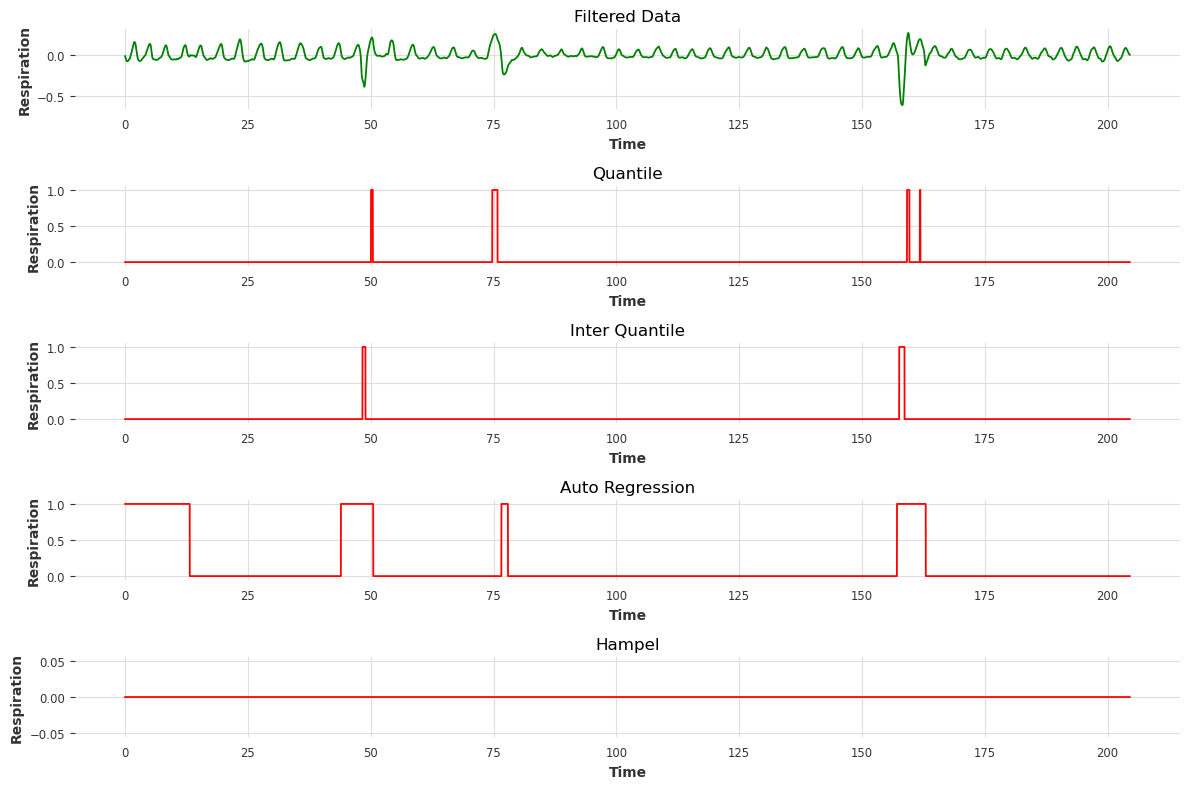

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\18\1_18-03-03.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.3795, 9.692)
Interval: (24.687, 25.4195)
Interval: (100.5595, 101.7075)
Interval: (121.972, 123.9145)
Interval: (209.438, 211.7305)
Interval: (241.2095, 242.692)
Interval: (282.18850000000003, 285.69)
Interval: (299.7725, 323.0195)
Starting Hampel Eval...
Hampel Fitting done...


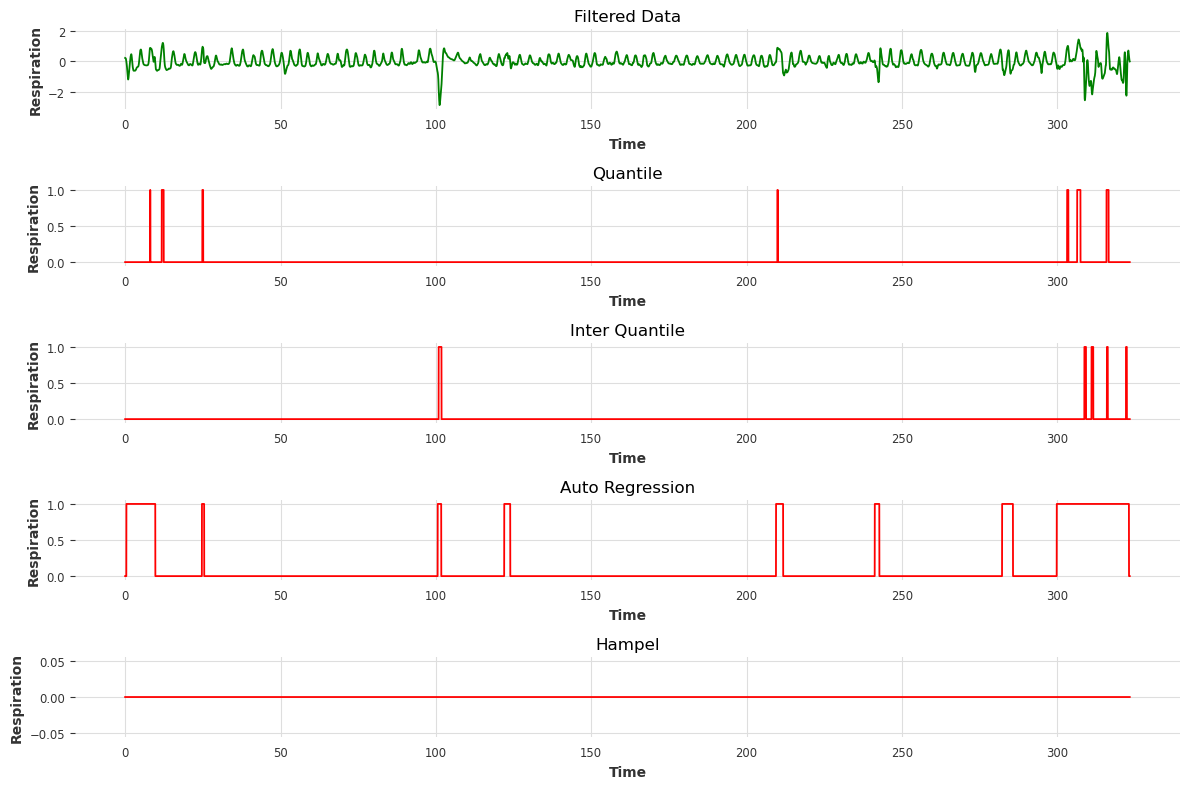

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\18\1_18-06-03.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (14.9575, 14.974)
Interval: (38.3965, 40.587)
Interval: (52.96, 53.8755)
Interval: (86.907, 94.775)
Interval: (104.831, 167.754)
Starting Hampel Eval...
Hampel Fitting done...


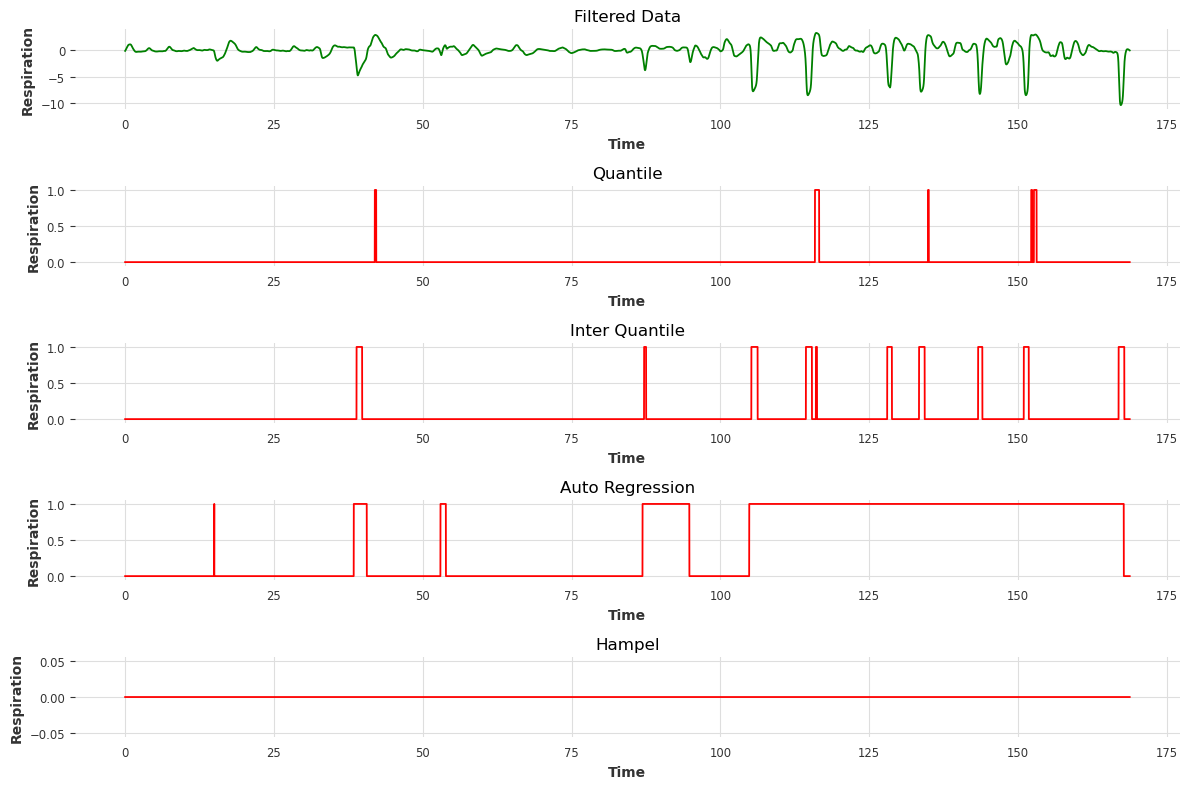

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\19\1_19-03-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (2.6975, 2.7585)
Interval: (52.8175, 56.8185)
Interval: (95.394, 95.418)
Interval: (133.6905, 134.3115)
Interval: (163.65200000000002, 174.30100000000002)
Starting Hampel Eval...
Hampel Fitting done...


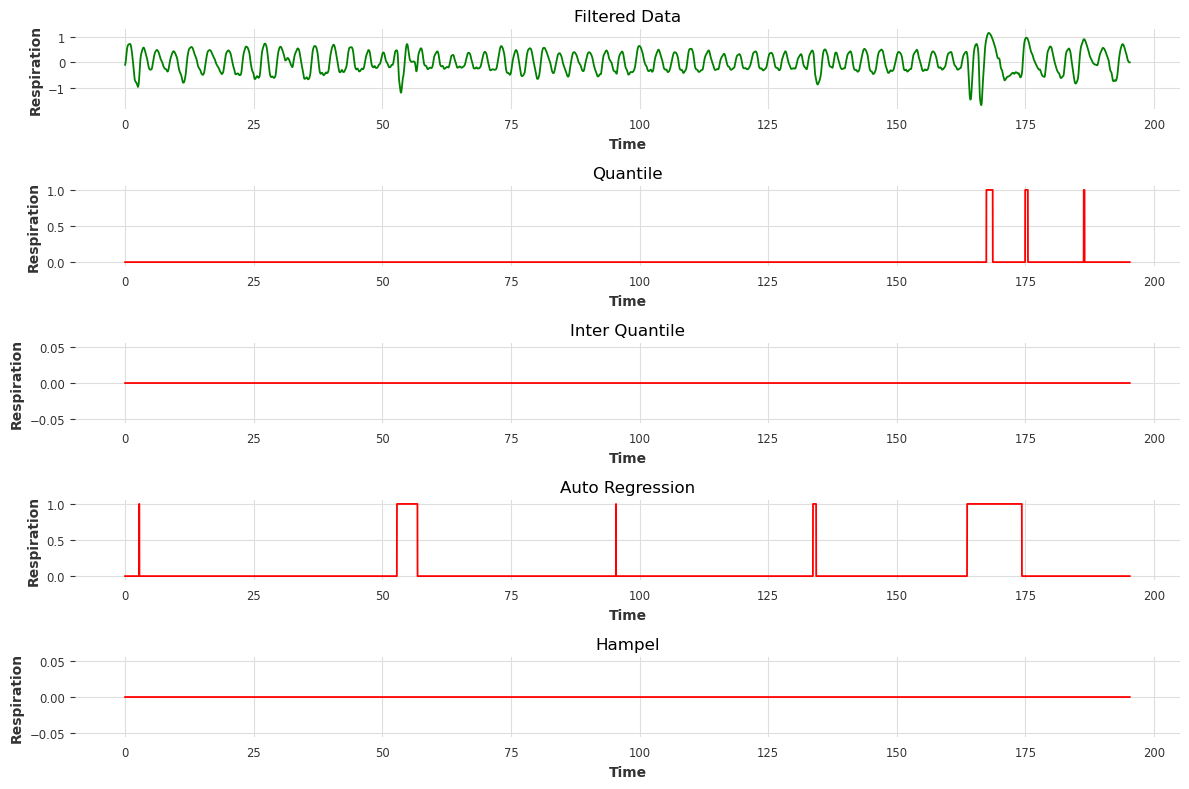

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\21\1_21-01-04.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.342, 0.3845)
Interval: (23.9585, 24.7875)
Starting Hampel Eval...
Hampel Fitting done...


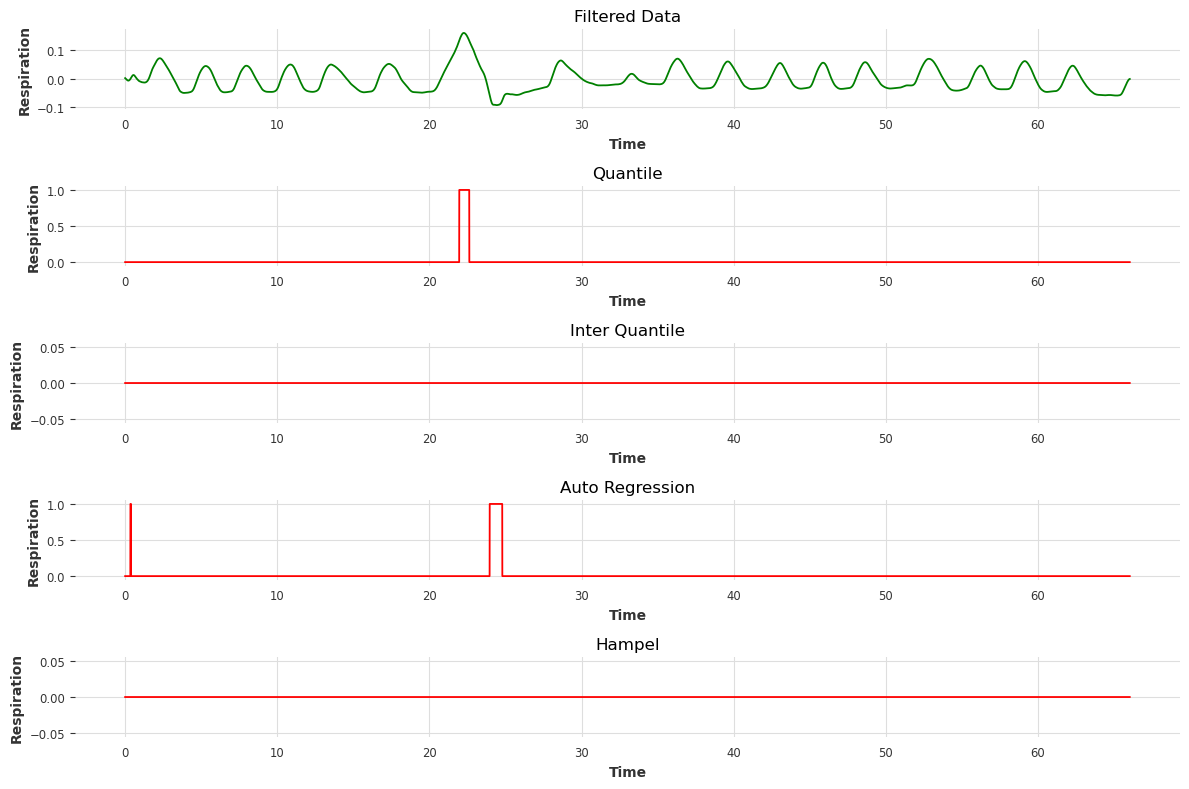

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\22\1_22-03-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.142, 5.2165)
Interval: (49.7755, 59.9165)
Interval: (79.0895, 79.0895)
Interval: (102.2485, 102.444)
Interval: (179.4005, 184.5075)
Starting Hampel Eval...
Hampel Fitting done...


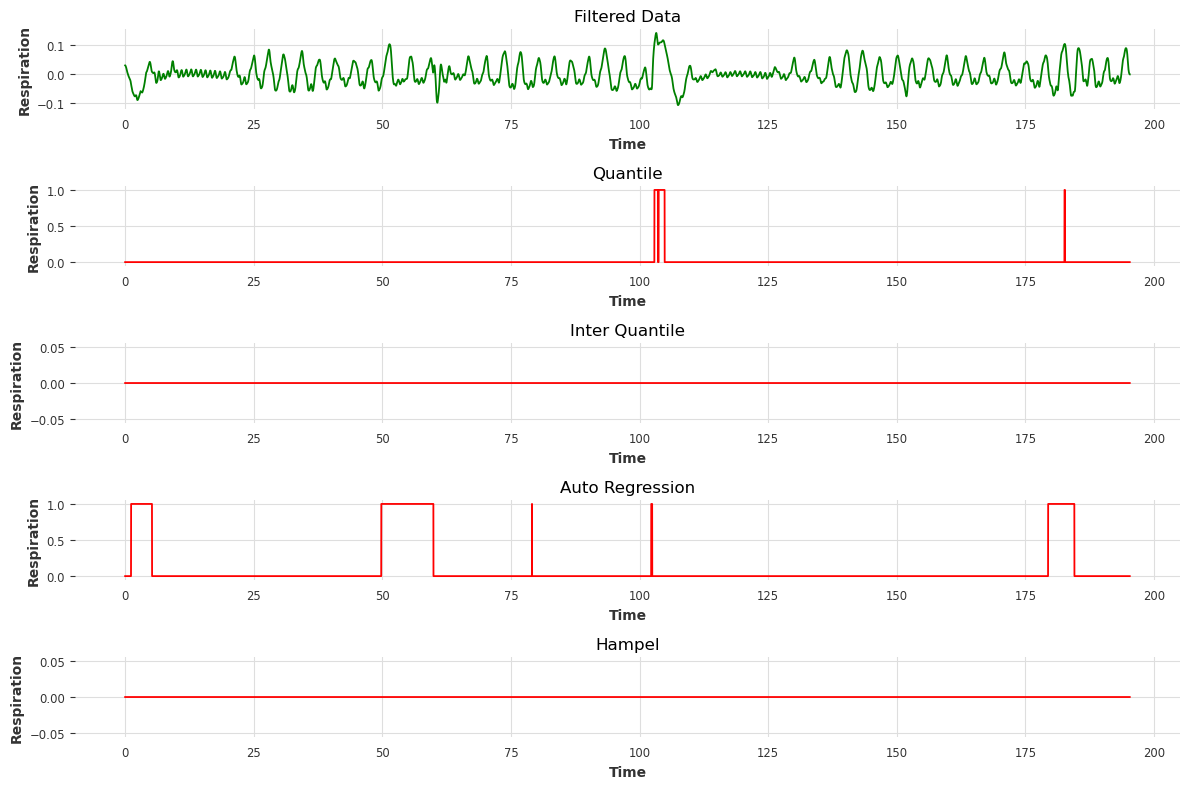

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\22\1_22-07-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (11.6305, 11.6305)
Interval: (24.8465, 24.8465)
Starting Hampel Eval...
Hampel Fitting done...


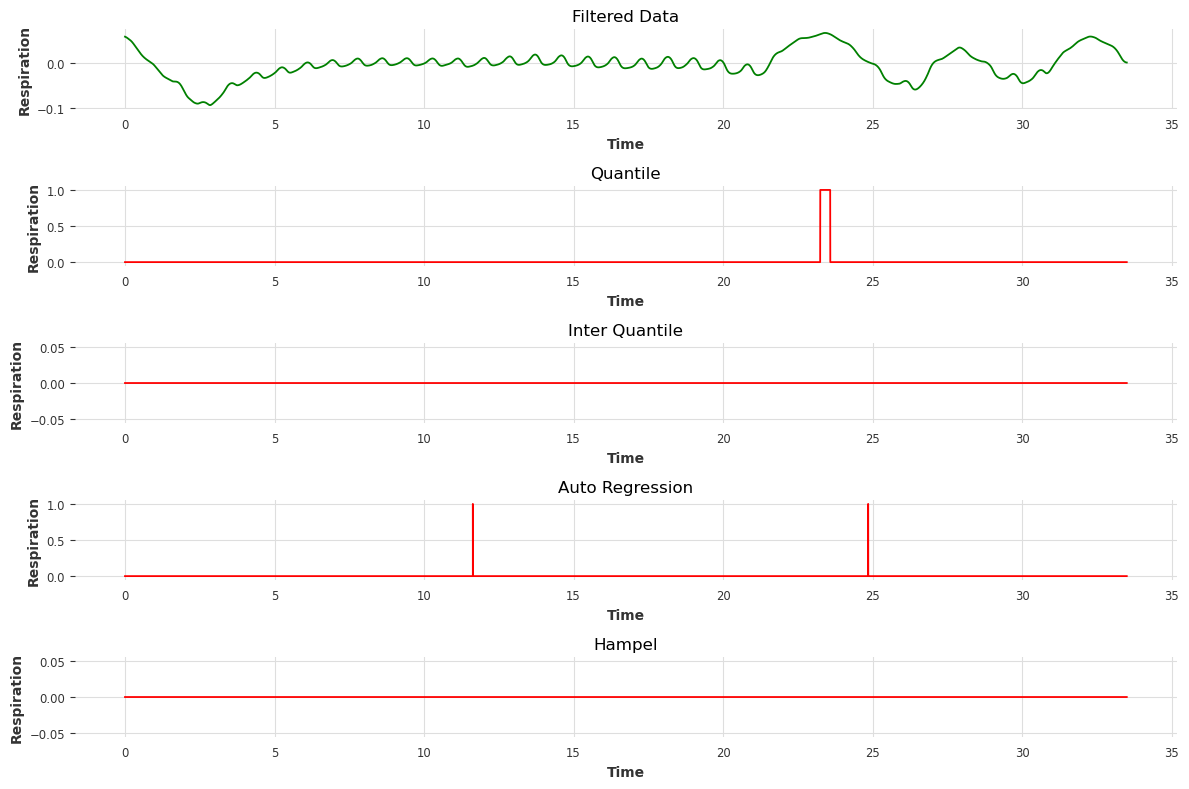

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\23\1_23-01-03.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (15.4635, 60.7155)
Starting Hampel Eval...
Hampel Fitting done...


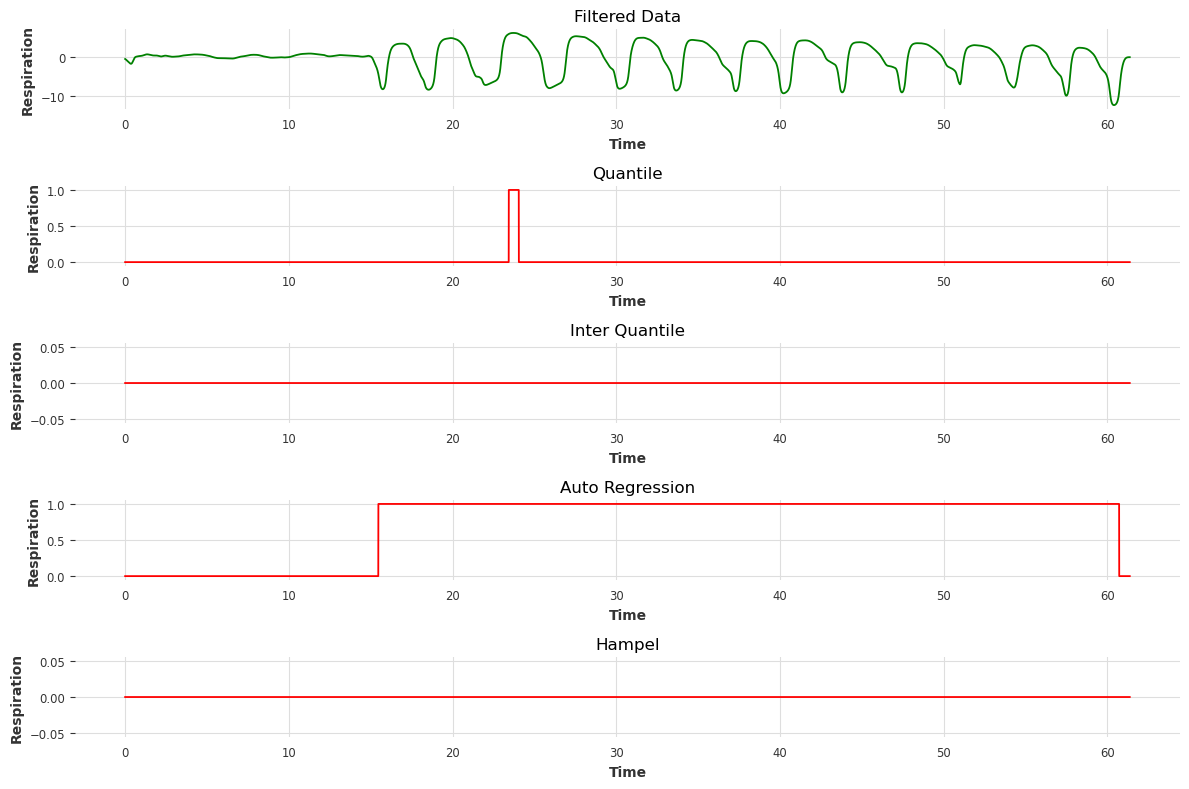

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\25\1_25-07-01.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (2.234, 24.6015)
Starting Hampel Eval...
Hampel Fitting done...


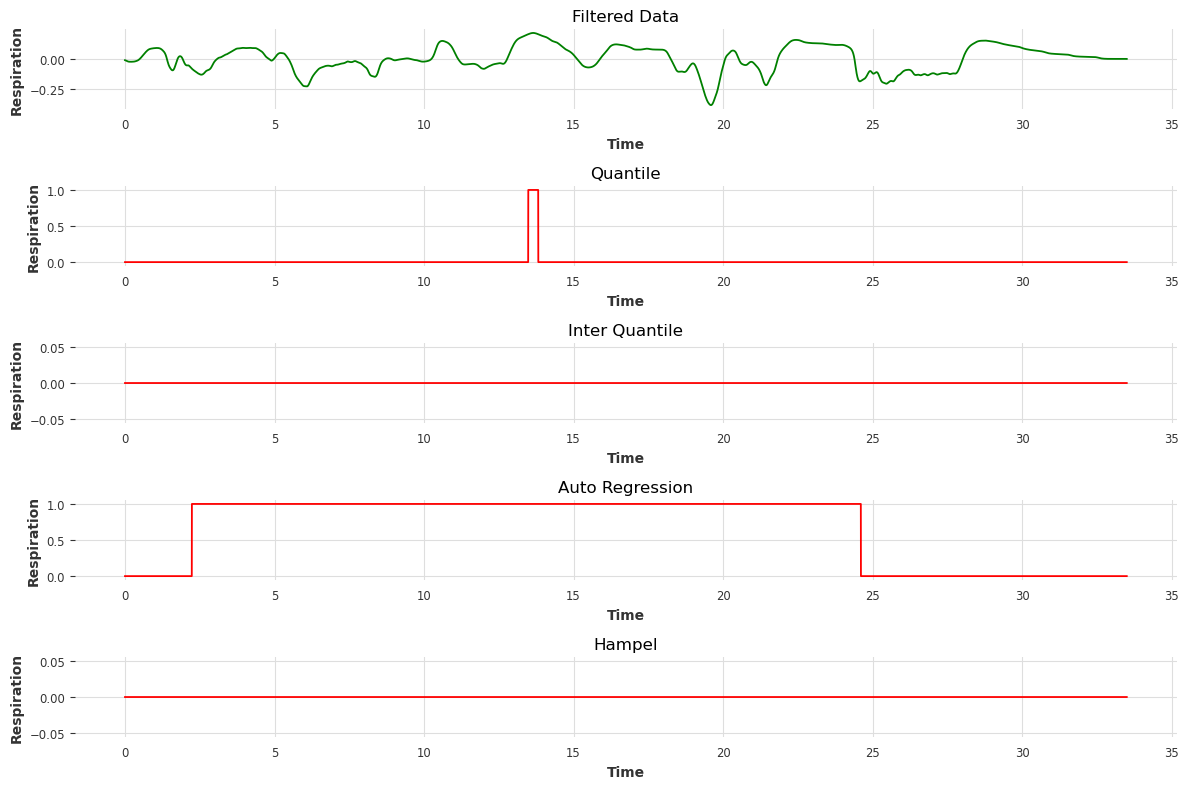

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\27\1_27-02-03.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.0005, 3.5535)
Interval: (26.1425, 26.151)
Interval: (41.145, 41.1615)
Interval: (140.543, 140.5715)
Starting Hampel Eval...
Hampel Fitting done...


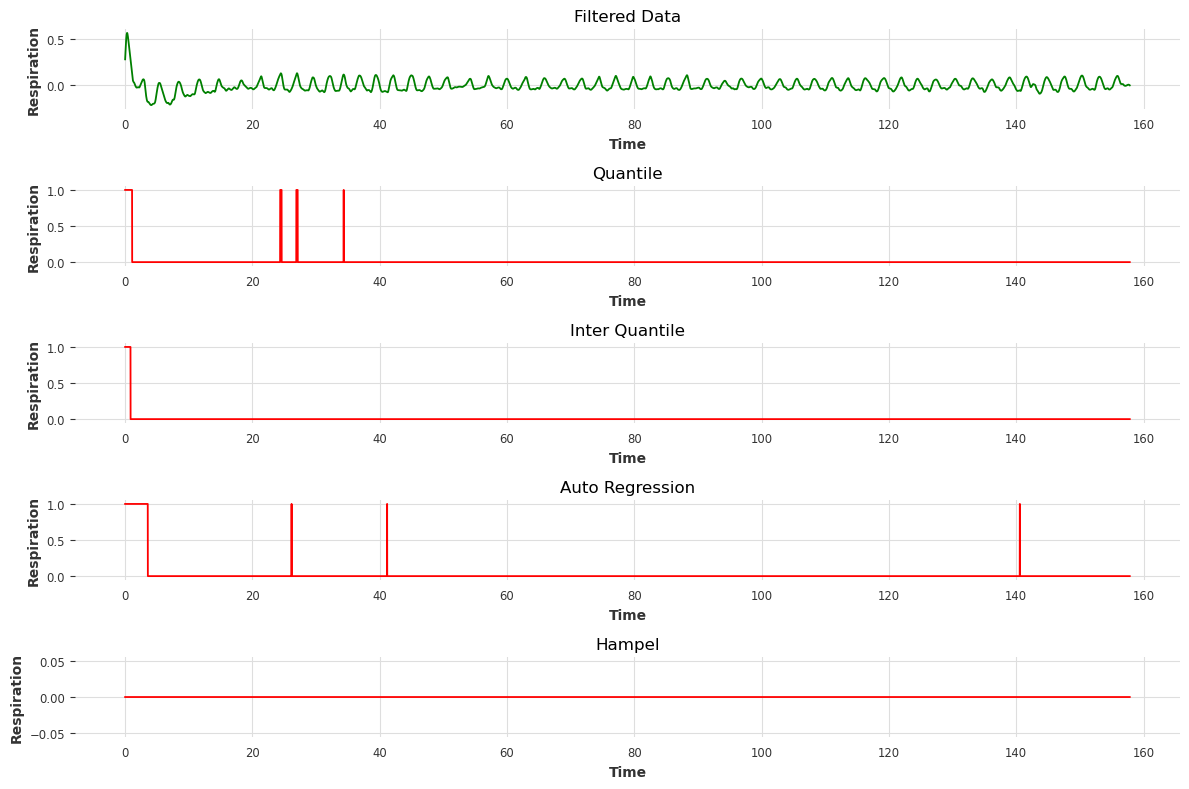

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\33\1_33-01-05.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (6.2255, 17.682)
Starting Hampel Eval...
Hampel Fitting done...


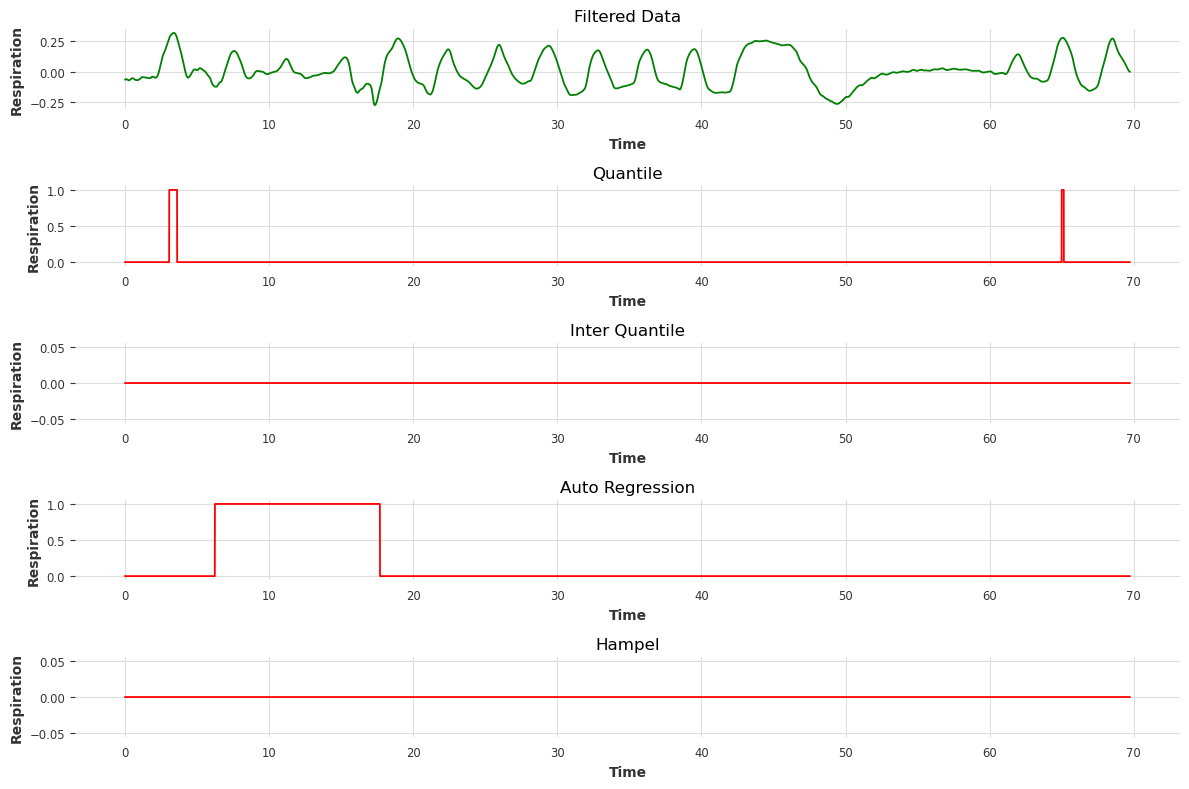

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\37\1_37-01-03.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (0.9525, 3.59)
Interval: (58.2665, 59.1105)
Starting Hampel Eval...
Hampel Fitting done...


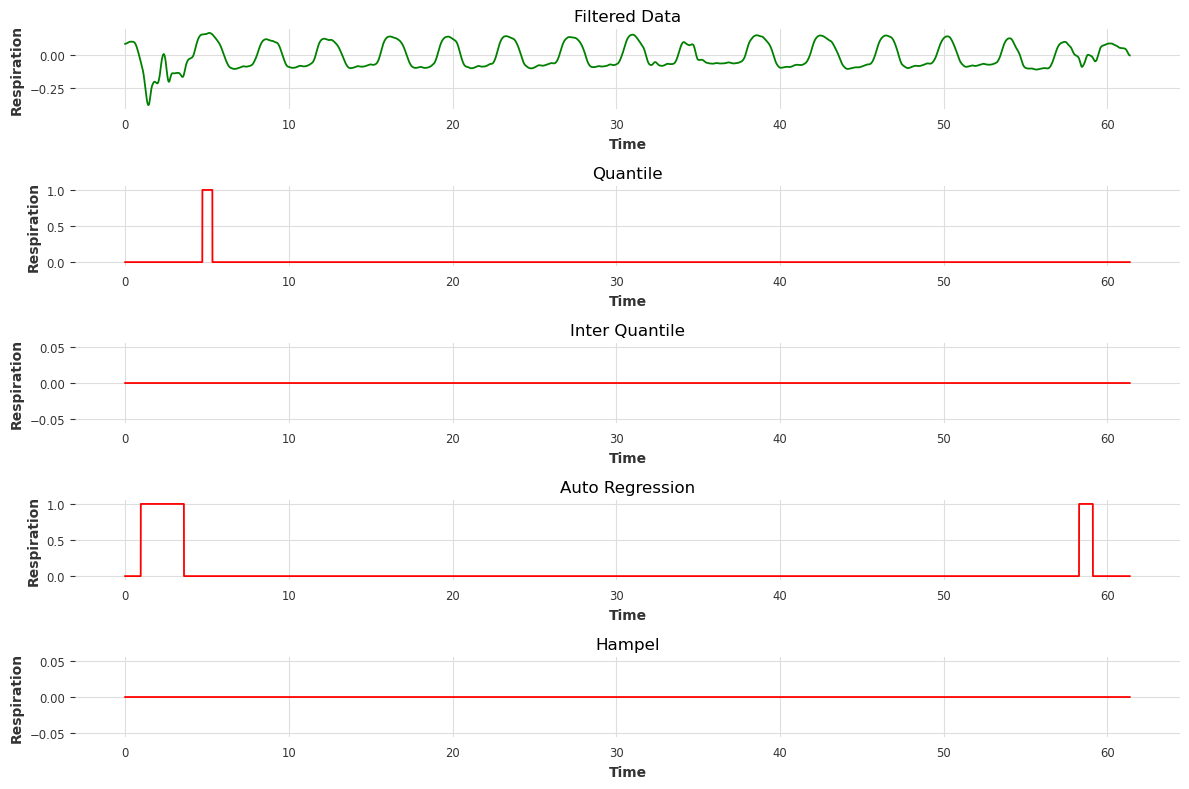

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\42\1_42-01-04.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (2.013, 4.4355)
Interval: (39.091, 39.1595)
Starting Hampel Eval...
Hampel Fitting done...


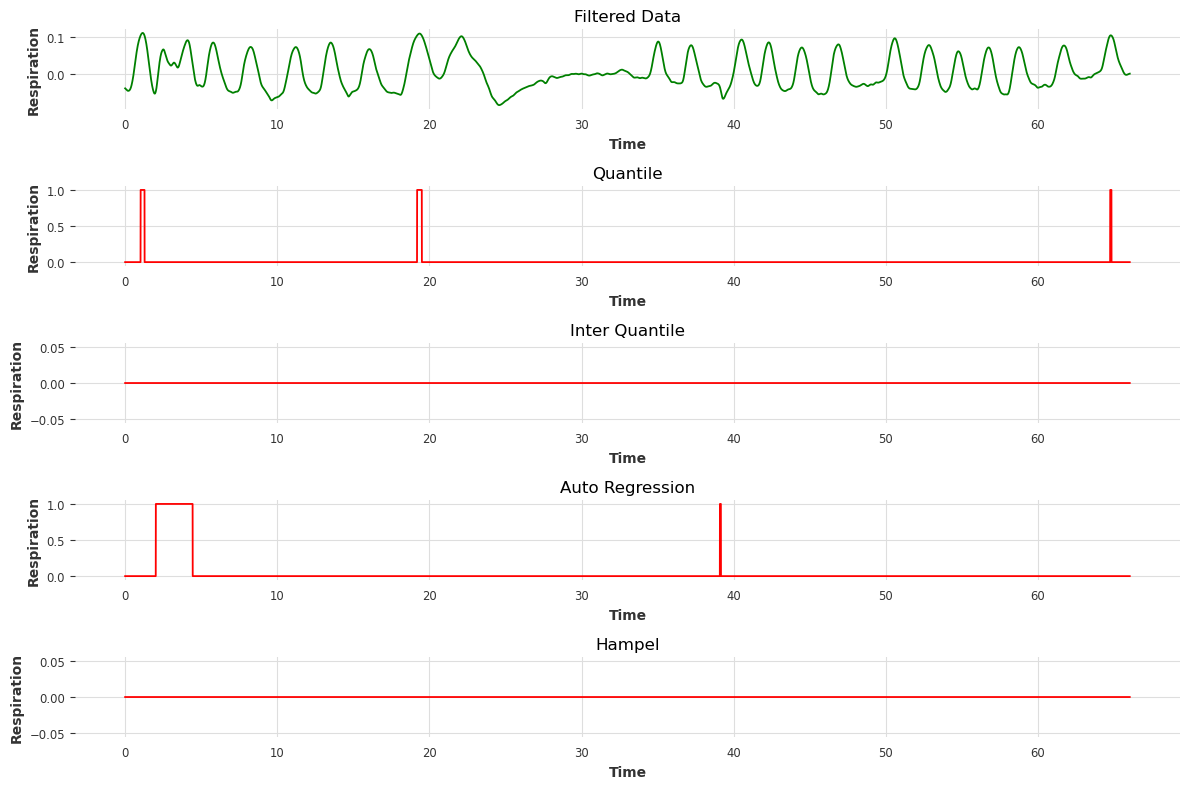

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\47\1_47-01-06.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (1.6595, 5.3155)
Starting Hampel Eval...
Hampel Fitting done...


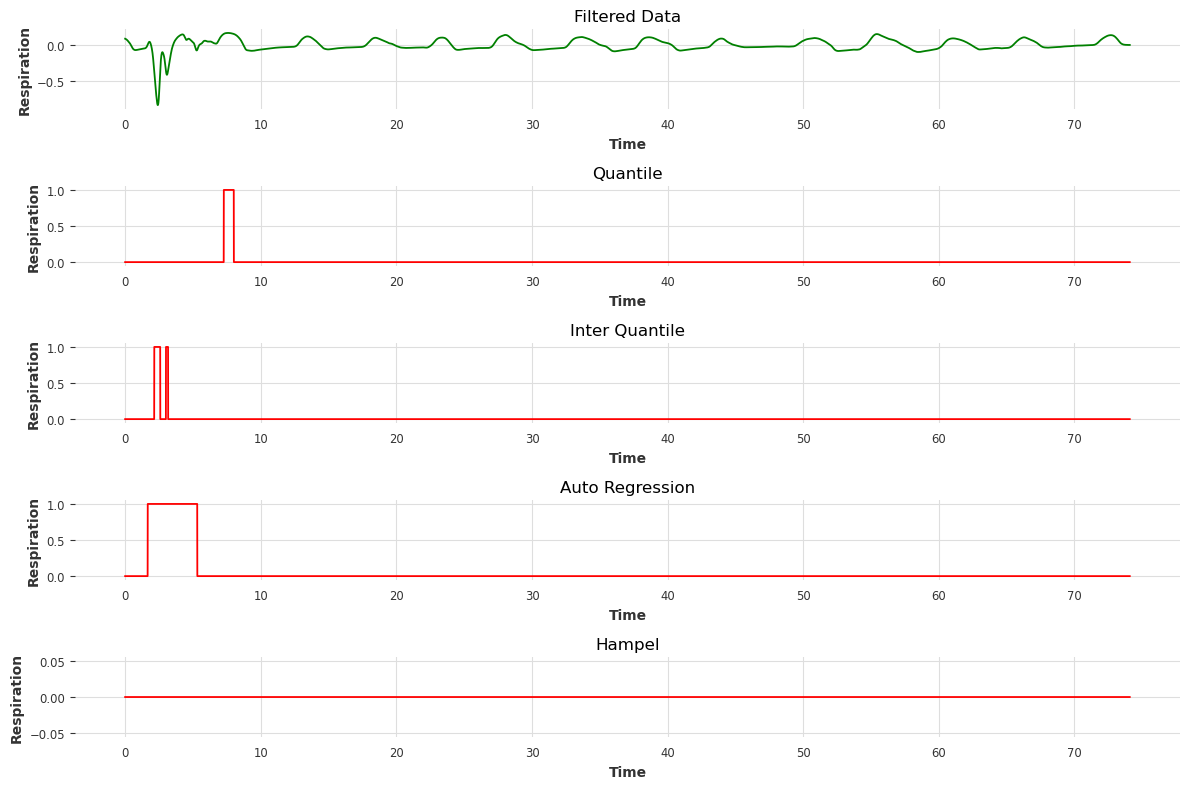

Processing file: D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered\48\1_48-07-03.csv
Fitting Detectors...
Intervals from AD_Format:
Interval: (4.7235000000000005, 4.7745)
Starting Hampel Eval...
Hampel Fitting done...


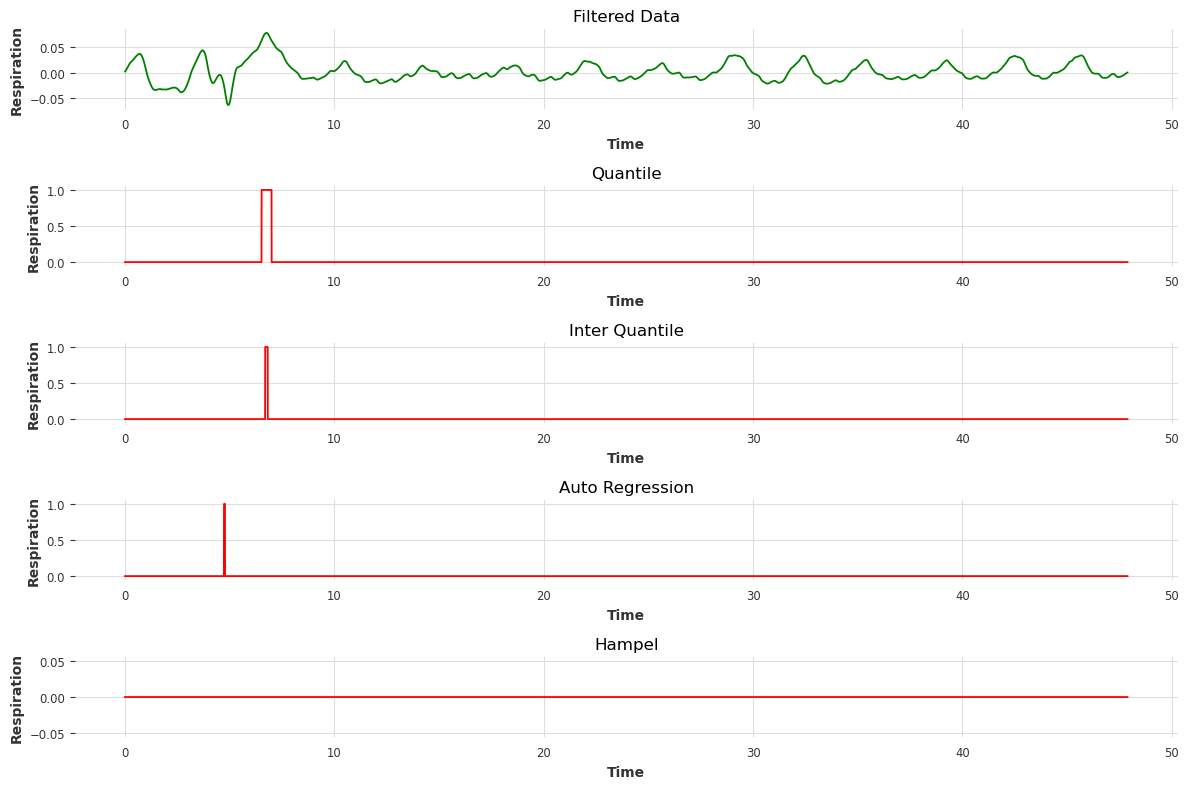

In [120]:
base_dir = r'D:\Thesis Data\Thesis Data\RepirationToolKit\data\1_filtered'
visible_anomalies_folder = 'visible anomalies'

# Loop through each file in the "visible anomalies" folder.
for file in os.listdir(visible_anomalies_folder):
    # Remove extension from file name.
    original_base = os.path.splitext(file)[0]
    # Replace the first character with '1'
    modified_base = "1" + original_base[1:]
    # Change extension from .png to .csv.
    new_file_name = modified_base + ".csv"
    
    # Extract subfolder name from the 3rd and 4th characters of the modified base.
    if len(modified_base) >= 4:
        subfolder = modified_base[2:4]
    else:
        print(f"File '{file}' does not have enough characters to extract a subfolder name.")
        continue
    
    # Construct the full file path.
    final_path = os.path.join(base_dir, subfolder, new_file_name)
    print(f"Processing file: {final_path}")

    Entry_filt = pd.read_csv(final_path)

    anomaly_det(Entry_filt, verbose=True, AD_c=5, AD_side="both", AD_n_steps=3, AD_step_size=100)


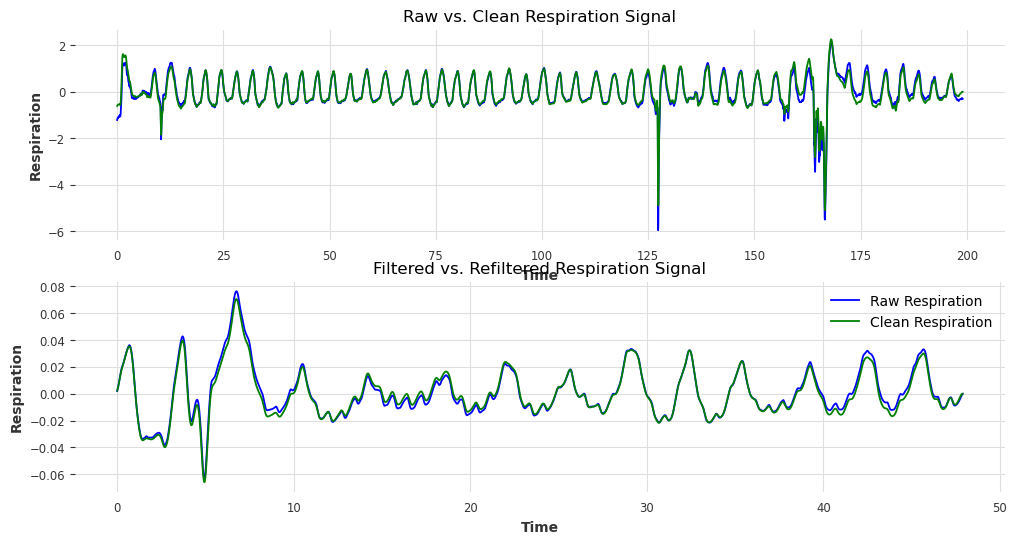

In [136]:
#khodadad2018
df_rsp, info = nk.rsp_process(Entry["Respiration"], sampling_rate=2000)

# Plot the raw and clean respiration signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(Entry["Time"], df_rsp["RSP_Raw"], label="Raw Respiration", color="b")
plt.plot(Entry["Time"], df_rsp["RSP_Clean"], label="Clean Respiration", color="g")

plt.title("Raw vs. Clean Respiration Signal")
plt.xlabel("Time")
plt.ylabel("Respiration")

# Try on Already Filtered vals
filt_df_rsp, filt_info = nk.rsp_process(Entry_filt["Respiration"], sampling_rate=2000)

# Plot the filt and refilt respiration signals
plt.subplot(2, 1, 2)
plt.plot(Entry_filt["Time"], filt_df_rsp["RSP_Raw"], label="Raw Respiration", color="b")
plt.plot(Entry_filt["Time"], filt_df_rsp["RSP_Clean"], label="Clean Respiration", color="g")

plt.title("Filtered vs. Refiltered Respiration Signal")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.show()

In [ ]:
#biosppy
df_rsp, info = nk.rsp_process(Entry["Respiration"], sampling_rate=2000, method="biosppy")

# Plot the raw and clean respiration signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(Entry["Time"], df_rsp["RSP_Raw"], label="Raw Respiration", color="b")
plt.plot(Entry["Time"], df_rsp["RSP_Clean"], label="Clean Respiration", color="g")

plt.title("Raw vs. Clean Respiration Signal")
plt.xlabel("Time")
plt.ylabel("Respiration")

# Try on Already Filtered vals
filt_df_rsp, filt_info = nk.rsp_process(Entry_filt["Respiration"], sampling_rate=2000, method="biosppy")

# Plot the filt and refilt respiration signals
plt.subplot(2, 1, 2)
plt.plot(Entry_filt["Time"], filt_df_rsp["RSP_Raw"], label="Raw Respiration", color="b")
plt.plot(Entry_filt["Time"], filt_df_rsp["RSP_Clean"], label="Clean Respiration", color="g")

plt.title("Filtered vs. Refiltered Respiration Signal")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.show()

In [ ]:
#hampel 
filtered = nk.rsp_clean(Entry["Respiration"], sampling_rate=2000, method="hampel")

# Plot the raw and clean respiration signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(Entry["Time"], Entry["Respiration"], label="Raw Respiration", color="b")
plt.plot(Entry["Time"], filtered, label="Clean Respiration", color="r")

plt.title("Raw vs. Clean Respiration Signal")
plt.xlabel("Time")
plt.ylabel("Respiration")

# Try on Already Filtered vals
refilt = nk.rsp_clean(Entry_filt["Respiration"], sampling_rate=2000, method="hampel")

# Plot the filt and refilt respiration signals
plt.subplot(2, 1, 2)
plt.plot(Entry_filt["Time"], Entry_filt["Respiration"], label="Raw Respiration", color="b")
plt.plot(Entry_filt["Time"], refilt, label="Clean Respiration", color="r")

plt.title("Filtered vs. Refiltered Respiration Signal")
plt.xlabel("Time")
plt.ylabel("Respiration")
plt.legend()
plt.show()

In [ ]:
filtered

In [ ]:
# Create a time axis with 10,000 points over a period (for example, 0 to 100 seconds)
time_values = np.linspace(0, 100, 10000)

# Create baseline respiratory values: a sine wave with some noise to simulate normal breathing
resp_values = 1 + 0.2 * np.sin(2 * np.pi * 0.1 * time_values) + 0.05 * np.random.randn(10000)

# Manually inject sections of outliers into the respiratory signal
# For example, at indices 2000-2100, 5000-5200, and 8000-8200, we set the values to be clearly different.
resp_values[2000:2100] = 2.0 + 0.05 * np.random.randn(100)  # High-value outliers
resp_values[5000:5200] = 0.2 + 0.05 * np.random.randn(200)  # Low-value outliers
resp_values[8000:8200] = 2.5 + 0.05 * np.random.randn(200)  # Another high-value outlier section

# Create a binary outlier indicator array: 0 means normal, 1 means outlier
outlier_indicator = np.zeros(10000)
outlier_indicator[2000:2100] = 1
outlier_indicator[5000:5200] = 1
outlier_indicator[8000:8200] = 1

# Plot the respiratory values and the outlier indicator
plt.figure(figsize=(12, 6))
plt.plot(time_values, resp_values, label="Respiratory Values", color='blue')
plt.plot(time_values, outlier_indicator, label="Outlier Indicator (0/1)", color='red', linestyle='--')

plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Respiratory Values with Sections of Outliers")
plt.legend()
plt.show()